In [1]:
#install packages
import idaes
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import json
from membrane_reactor_v2 import plot_pd
from membrane_reactor_v2 import CO_conversion, H2_recovery, feed_utilization_efficiency

In [2]:
# Specify case based on input dataset.
# # PCI-10: bench-scale laboratory  data supplied by PCI - 
# # PCI-H2A: bench-scale laboratory data on membrane performance combined with industrial gas properties from the NREL H2A model report - 
# #            corresponds to dataset in Table 3 in paper
# # public: data published in Brunetti 2007 https://doi.org/10.1016/j.memsci.2007.09.009
# # public-H2A: membrane perfromance data from Brunetti 2007 combined with industrial gas properties from the NREL H2A model report

data_case = 'PCI-H2A'
savefig = True
savedata = False

In [3]:
# read data from json file
data_path = 'WGSMR_data_{}'.format(data_case)
with open(data_path, 'r') as source_file:
    data = json.load(source_file)

In [4]:
def create_model(
    temp_reactor=553,
    CO_comp_feed=0.2,
    H2O_comp_feed=0.2,
    CO2_comp_feed=0.1,
    H2_comp_feed=0.5,
    CH4_comp_feed=0,
    N2_comp_feed=0,
    feed_pressure=1e6,
    pressure_drop_retentate=35000,
    CO_comp_sweep=0,
    H2O_comp_sweep=0,
    CO2_comp_sweep=0,
    H2_comp_sweep=0,
    CH4_comp_sweep=0,
    N2_comp_sweep=1,
    sweep_pressure=1e5,
    sweep_ghsv=0,
    pressure_drop_permeate=0,
    pre_exponent=0.0162,
    E_R=3098,
    pressure_exponent=0.5,
    vol_reactor=3.927e-5,
    area_membrane=0.0157,
    rho_catalyst=1.38e3,
    num_elements=20,
    no_permeation=False,
    Tmin=300,
    Tmax=800,
    initialize_pressure_strategy="constant",
    zoned_temperature=False,
    num_zones=1
):
    """
    Creates a cooncrete pyomo model for the water-gas shift membrane reactor

    Arguments:
        temp_reactor: float, temperature of membrane reactor in [K]
        CO_comp_feed: float, molar composition of CO in the feed [unitless]
        H2O_comp_feed: float, molar composition of water in the feed [unitless]
        CO2_comp_feed: float, molar composition of CO2 in the feed [unitless]
        H2_comp_feed: float, molar composition of H2 in the feed [unitless]
        feed_pressure: float, feed pressure in [Pa]
        pressure_drop_retentate: float, total pressure drop on retentate-side [Pa]. We assumed 3.5% of feed pressure as default.
        CO_comp_sweep: float, molar composition of CO in the sweep [unitless]
        H2O_comp_sweep: float, molar composition of water in the sweep [unitless]
        CO2_comp_sweep: float, molar composition of CO2 in the sweep [unitless]
        H2_comp_sweep: float, molar composition of H2 in the sweep [unitless]
        sweep_pressure: float, sweep pressure in [Pa]
        sweep_ghsv: float, sweep GHSV [hr-1]
        pressure_drop_permeate: float, total pressure drop on permeate-side [Pa]. We assumed 3.5% of sweep pressure.
        pre_exponent: float, pre-exponential factorfor hydrogen permeation in temp_reactor
        E_R: float, Activation energy of hydrogen diffusion, E over universal gas consant, R, in [K]
        pressure_exponent: float, partial pressure exponent
        vol_reactor: float, volume of catalyst packing/bed in [m3]
        area_membrane: float, effective/permeation area of membrane in [m2]
        rho_catalyst: float, density of catalyst in [kg/m3]
        num_elements: int, number of finite elements [unitless]
        no_permeation: boolean, used to activate conventional equilibrium reaction without permeation
        initialize_pressure_strategy: str, "constant" or "linear", toggle to specify mode of pressure initialization


    Returns:
        m: concreete pyomo model
    """

    ########### MODEL SET-UP AND PRELIMINARY DATA

    # Create instance of a concrete pyomo model
    m = pyo.ConcreteModel()

    # Specify number of finite elelments
    m.N = num_elements
    
    # specify number of zones
    m.num_zones = pyo.Param(initialize=num_zones, mutable=True)
    
    # specify correction factor for partial pressure
    corr_factor = 1e-8

    # Declare set of gas components
    m.COMPONENTS = pyo.Set(initialize=["CO", "H2O", "CO2", "H2","CH4", "N2"])

    # Declare set of finite elements
    m.ELEMENTS = pyo.Set(initialize=range(0, m.N))

    # assemble feed composition
    feed_comp = {
        "CO": CO_comp_feed,
        "H2O": H2O_comp_feed,
        "CO2": CO2_comp_feed,
        "H2": H2_comp_feed,
        "CH4": CH4_comp_feed,
        "N2": N2_comp_feed 
    }  # component flow rates in [mol/s].

    # assemble sweep composition
    sweep_comp = {
        "CO": CO_comp_sweep,
        "H2O": H2O_comp_sweep,
        "CO2": CO2_comp_sweep,
        "H2": H2_comp_sweep,
        "CH4": CH4_comp_sweep,
        "N2": N2_comp_sweep
    }  # component flow rates in [mol/s].

    # Specify stoichiometric coefficient
    stoichiometric_ceofficients = {
        "CO": -1,
        "H2O": -1,
        "CO2": 1,
        "H2": 1,
        "CH4": 0,
        "N2": 0,
    }  # stoichiometric coefficients in water-gas shift reaction

    # Generate data for initialize pressure
    p_retentate_list = np.linspace(
        feed_pressure, feed_pressure - pressure_drop_retentate, num_elements
    )

    # Generate data for initializing permeate-side pressure
    p_permeate_list = np.linspace(
        sweep_pressure - pressure_drop_permeate, sweep_pressure, num_elements
    )

    ########### MODEL PARAMETERS

    # pre-exponential factor for permeance in hydrogen flux [mol/m2-s-Pa^(0.5)]
    m.pre_exponential_factor = pyo.Param(initialize=pre_exponent)

    # universal gas constant 
    m.R = pyo.Param(initialize=8.3145) # J/mol/K

    m.T_stp = pyo.Param(initialize=273) # K
    m.P_stp = pyo.Param(initialize=101325) # Pa

    # ratio of activation energy for hydrogen permeation to universal gas constant [K]
    m.E_R = pyo.Param(
        initialize=E_R
    )  # Reformulate to take only value of E, value of R will be specified as a constant under inputs

    # partial pressure exponent
    m.n = pyo.Param(initialize=pressure_exponent)

    # reaction volume per finite element [m3]
    m.volume = pyo.Param(initialize=vol_reactor)

    # permeation area per finite element [m2]
    m.area = pyo.Param(initialize=area_membrane)

    # catalyst density [kg/m3]
    m.rho_catalyst = pyo.Param(initialize=rho_catalyst)

    # feed pressure [Pa]
    m.pressure_feed = pyo.Param(initialize=feed_pressure,mutable=True)

    # sweep pressure [Pa]
    m.pressure_sweep = pyo.Param(initialize=sweep_pressure)
    
    # sweep to feed GHSV ratio
    m.sweep_ghsv = pyo.Param(initialize=sweep_ghsv,mutable=True)

    # pressure drop in retentate/shell [Pa]
    m.delta_p_retentate = pyo.Param(initialize=pressure_drop_retentate)

    # pressure drop in permeate/tube [Pa]
    m.delta_p_permeate = pyo.Param(initialize=pressure_drop_permeate)

    # feed composition
    m.y_feed = pyo.Param(m.COMPONENTS, initialize=feed_comp)

    # feed composition
    m.y_sweep = pyo.Param(m.COMPONENTS, initialize=sweep_comp)

    # stoichiometric coefficients for water-gas shift reaction
    m.coeff = pyo.Param(m.COMPONENTS, initialize=stoichiometric_ceofficients)
    
    ########### MODEL VARIABLES 

    #max_flow_rate = 1.256e-1
    max_flow_rate = 1.0
    
    # reactor temperature
    # m.temp_retentate = pyo.Param(m.ELEMENTS,initialize=temp_reactor)
    m.temp_retentate = pyo.Var(m.ELEMENTS,initialize=temp_reactor,bounds=(Tmin,Tmax))
    
    
    # ghsv
    m.ghsv = pyo.Var(initialize=3000,bounds=(250,4500))
    
    # retentate-side component molar flow rate [mol/s]
    m.flow_retentate = pyo.Var(
        m.ELEMENTS, m.COMPONENTS, initialize=3e-4, bounds=(0, max_flow_rate))

    # permeate-side component molar flow rate [mol/s]
    m.flow_permeate = pyo.Var(
        m.ELEMENTS, m.COMPONENTS, initialize=3e-4, bounds=(0, max_flow_rate))

    # retentate-side molar composition
    m.composition_retentate = pyo.Var(
        m.ELEMENTS, m.COMPONENTS, initialize=0.5, bounds=(0, 1))

    # permeate-side molar composition
    m.composition_permeate = pyo.Var(
        m.ELEMENTS, m.COMPONENTS, initialize=0.5, bounds=(0, 1))

    pressure_lower_bound = 1e3  # in Pa
    pressure_upper_bound = 1e7  # in Pa

    if initialize_pressure_strategy == "linear":
        # initialize retentate pressure
        m.retentate_pressure_init = {}
        for i, v in enumerate(m.ELEMENTS):
            m.retentate_pressure_init[v] = p_retentate_list[i]
        # retentate pressure [Pa]
        m.pressure_retentate = pyo.Var(
            m.ELEMENTS,
            initialize=m.retentate_pressure_init,
            bounds=(pressure_lower_bound, pressure_upper_bound))
        # initialize permeate pressure
        m.permeate_pressure_init = {}
        for i, v in enumerate(m.ELEMENTS):
            m.permeate_pressure_init[v] = p_permeate_list[i]
        # permeate pressure [Pa]
        m.pressure_permeate = pyo.Var(
            m.ELEMENTS,
            initialize=m.permeate_pressure_init,
            bounds=(pressure_lower_bound, pressure_upper_bound))
        
    elif initialize_pressure_strategy == "constant":
        # retentate pressure [Pa]
        m.pressure_retentate = pyo.Var(
            m.ELEMENTS,
            initialize=1e5,
            bounds=(pressure_lower_bound, pressure_upper_bound))

        # permeate pressure [Pa]
        m.pressure_permeate = pyo.Var(
            m.ELEMENTS,
            initialize=1e5,
            bounds=(pressure_lower_bound, pressure_upper_bound))
    else:
        raise ValueError(
            "initialize_pressure_strategy must be either 'linear' or 'constant'")
        
    # max_reaction_rate = 1e-1
    max_reaction_rate = 10
    
    # reaction rate [mol/g/min]
    m.reaction_rate = pyo.Var(
        m.ELEMENTS, initialize=0.00509365, domain=pyo.NonNegativeReals
        )  #Initial value obtained by manual calculation of expected reaction rate. BEST PRACTICE: initialize reaction rate using the 
    # init_reaction_rate function, thus this initial value does not matter.

    ########### MODEL CONSTRAINTS

    # retentate-side pressure drop constraint (Equation 6)
    def RetentatePressureDropRule(m, j):
        if j == m.ELEMENTS.first():
            return (m.pressure_retentate[j] == m.pressure_feed
            )  # feed pressure boundary condition
        return (m.pressure_retentate[j]
            == m.pressure_retentate[j - 1] - m.delta_p_retentate / m.N)

    m.retentate_pressure_constraint = pyo.Constraint(
        m.ELEMENTS, rule=RetentatePressureDropRule)

    # permeate-side pressure drop constraint (Equation 7)
    def PermeatePressureDropRule(m, j):
        if j == m.ELEMENTS.last():
            return (m.pressure_permeate[j] == m.pressure_sweep
            )  # sweep pressure boundary condition
        return (
            m.pressure_permeate[j]
            == m.pressure_permeate[j + 1] - m.delta_p_permeate / m.N)

    m.permeate_pressure_constraint = pyo.Constraint(
        m.ELEMENTS, rule=PermeatePressureDropRule)

    # flux expression (Eqution 3)
    def MembraneFluxRule(m, j, i):
        if no_permeation:
            return 0
        else:
            if i == "H2":
                return (m.pre_exponential_factor*pyo.exp(-m.E_R / m.temp_retentate[j]) * (
                    (abs(m.pressure_retentate[j] * m.composition_retentate[j, i]
                            + corr_factor))
                    ** m.n - (abs(m.pressure_permeate[j] * m.composition_permeate[j, i]
                            + corr_factor)) ** m.n))
            return 0  # infinite selectivity for hydrogen
    m.N_flux = pyo.Expression(m.ELEMENTS, m.COMPONENTS, rule=MembraneFluxRule)

    # reaction rate constraint (Equation 4)
    def ReactionRateRule(m, j):
        return m.reaction_rate[j] * (0.0126 * pyo.exp(4639 / m.temp_retentate[j])) * (
            1
            + 1.0197e-5
            * m.pressure_retentate[j]
            * (
                2.2
                * pyo.exp(101.5 / m.temp_retentate[j])
                * m.composition_retentate[j, "CO"]
                + 0.4
                * pyo.exp(158.3 / m.temp_retentate[j])
                * m.composition_retentate[j, "H2O"]
                + 0.047
                * pyo.exp(2737.9 / m.temp_retentate[j])
                * m.composition_retentate[j, "CO2"]
                + 0.05
                * pyo.exp(596.1 / m.temp_retentate[j])
                * m.composition_retentate[j, "H2"]
            )
        ) ** 2 == 0.92 * pyo.exp(
            -454.3 / m.temp_retentate[j]
        ) * 1.03982e-10 * m.pressure_retentate[j] ** 2 * (
            m.composition_retentate[j, "CO"]
            * m.composition_retentate[j, "H2O"]
            * (0.0126 * pyo.exp(4639 / m.temp_retentate[j]))
            - m.composition_retentate[j, "CO2"] * m.composition_retentate[j, "H2"]
        )
    m.reaction_rate_constraint = pyo.Constraint(m.ELEMENTS, rule=ReactionRateRule)

    # retentate-side material balance (Equation 1)
    # define constraint rule (index over j and i)
    def RetentateMaterialRule(m, j, i):
        if j == m.ELEMENTS.first():
            element_feed = m.y_feed[i] # feed boundary condition. Divide by "total_feed" to make dimensionless
        else:
            element_feed = m.flow_retentate[j - 1, i] # prior element in cascade
        return (m.flow_retentate[j, i]
            == element_feed
            + m.coeff[i] * m.reaction_rate[j] * 16.6667 * m.rho_catalyst * 3600*m.R*m.T_stp/(m.N*m.P_stp*m.ghsv)
            - m.N_flux[j, i] * m.area / m.volume * 3600*m.R*m.T_stp/(m.N*m.P_stp*m.ghsv))  # multiply by 16.6667 to convert reaction rate from [mol/g/min] to [mol/kg/s]. # Divide by "total_feed" to make dimensionless

    m.retentate_material_constraint = pyo.Constraint(
        m.ELEMENTS, m.COMPONENTS, rule=RetentateMaterialRule)

    # permeate-side material balance (Equation 2)
    def PermeateMaterialBalanceRule(m, j, i):
        if j == m.ELEMENTS.last():
            element_feed = m.y_sweep[i]*m.sweep_ghsv/m.ghsv # y_sweep*ghsv_sweep/ghsv_feed
        else:
            element_feed = m.flow_permeate[j + 1, i] # next element in cascade
        return (
            m.flow_permeate[j, i] == element_feed + m.N_flux[j, i] * m.area / m.volume * 3600*m.R*m.T_stp/(m.N*m.P_stp*m.ghsv)
        ) # Divide by "total_feed" to make dimensionless

    m.permeate_material_constraint = pyo.Constraint(
        m.ELEMENTS, m.COMPONENTS, rule=PermeateMaterialBalanceRule)

    # retentate-side molar composition constraint (Equation 8)
    def RetentateCompositionRule(m, j, i):
        return (m.composition_retentate[j, i]
            * sum(m.flow_retentate[j, i] for i in m.COMPONENTS)
            == m.flow_retentate[j, i])
    m.retentate_composition_constraint = pyo.Constraint(
        m.ELEMENTS, m.COMPONENTS, rule=RetentateCompositionRule)

    # permeate-side molar composition constraint (Equation 9)
    def PermeateCompositionRule(m, j, i):
        return (m.composition_permeate[j, i]
            * sum(m.flow_permeate[j, i] for i in m.COMPONENTS)
            == m.flow_permeate[j, i])
    m.permeate_composition_constraint = pyo.Constraint(
        m.ELEMENTS, m.COMPONENTS, rule=PermeateCompositionRule)

    ### Add constraint to zone temperature #################
    if zoned_temperature:
        # Estimate the number of elements per zone
        elements_per_zone = int(m.N/m.num_zones())
        print('elements per zone =', elements_per_zone)

        # Collect the elements that are the end of each zone
        zone_end_elements = [(elements_per_zone * (i + 1)-1) for i in range(m.num_zones())]
        print('zone end elements =',zone_end_elements)

        # define constraint rule
        def zone_temperature_rule(m):
            for element in zone_end_elements:
                    #print("zone element:",element)
                    for i in range(1,elements_per_zone):
                        print(m.temp_retentate[element - i], "== ",m.temp_retentate[element])
                        yield m.temp_retentate[element - i] == m.temp_retentate[element]

        m.zone_temperature_constraint = pyo.ConstraintList(rule=zone_temperature_rule)


    ###########################################
    
    # define objective
    def ObjectiveRule(m):
        return m.flow_permeate[m.ELEMENTS.first(), "H2"]
    m.OBJ = pyo.Objective(rule=ObjectiveRule, sense=pyo.maximize)

    return m


In [5]:
# helper functions
# turn OFF reactions for initialization step
def toggle_reaction_off(m):
    """
    Function to deactiavte reaction from the membrane reactor model

    Argument:
        m: concrete pyomo model of membrane reactor

    return:
        nill
    """
    # deactivate reaction rate constraint in model
    m.reaction_rate_constraint.deactivate()

    # fix reaction rate, set to zero
    m.reaction_rate.fix(0)

# turn ON reactions
def toggle_reaction_on(m):
    """
    Function to activate reaction in membrane reactor model

    Argument:
        m: concrete pyomo model

    return:
        nill
    """
    # unfix reaction rate
    m.reaction_rate.unfix()

    # activate reaction rate constraint
    m.reaction_rate_constraint.activate()

# initialize reaction rate
def init_reaction_rate(m):
    """
    Function to initialize reaction_rate variable using output from previous solve

    Argument:
        m: concrete Pyomo model

    Return:
        nill
        
    Other:
        This function is only useful when there is a solved results for the model to use as initialization point

    """
    for j in m.ELEMENTS:
        m.reaction_rate[j] = 0.92 * pyo.exp(
            -454.3 / m.temp_retentate[j]
        ) * 1.03982e-10 * m.pressure_retentate[j] ** 2 * (
            m.composition_retentate[j, "CO"]
            * m.composition_retentate[j, "H2O"]
            * (0.0126 * pyo.exp(4639 / m.temp_retentate[j]))
            - m.composition_retentate[j, "CO2"] * m.composition_retentate[j, "H2"]
        ) / (0.0126 * pyo.exp(4639 / m.temp_retentate[j])) * (1 + 1.0197e-5
            * m.pressure_retentate[j]
            * (2.2
                * pyo.exp(101.5 / m.temp_retentate[j])
                * m.composition_retentate[j, "CO"]
                + 0.4
                * pyo.exp(158.3 / m.temp_retentate[j])
                * m.composition_retentate[j, "H2O"]
                + 0.047
                * pyo.exp(2737.9 / m.temp_retentate[j])
                * m.composition_retentate[j, "CO2"]
                + 0.05
                * pyo.exp(596.1 / m.temp_retentate[j])
                * m.composition_retentate[j, "H2"])) ** 2

        
def init_reaction_rate_from_different_model(m,ref_model):
    """
    Function to initialize reaction_rate variable using output from previous solve

    Argument:
        m: concrete Pyomo model
        ref_model: solved pyomo model used as base for initialization

    Return:
        nill
        
    Other:
        This function is only useful when there is a solved results for the model to use as initialization point

    """
    for j in m.ELEMENTS:
        m.reaction_rate[j] = 0.92 * pyo.exp(
            -454.3 / ref_model.temp_retentate[j]
        ) * 1.03982e-10 * m.pressure_retentate[j] ** 2 * (
            ref_model.composition_retentate[j, "CO"]
            * ref_model.composition_retentate[j, "H2O"]
            * (0.0126 * pyo.exp(4639 / ref_model.temp_retentate[j]))
            - ref_model.composition_retentate[j, "CO2"] * ref_model.composition_retentate[j, "H2"]
        ) / (0.0126 * pyo.exp(4639 / ref_model.temp_retentate[j])) * (1 + 1.0197e-5
            * ref_model.pressure_retentate[j]
            * (2.2
                * pyo.exp(101.5 / ref_model.temp_retentate[j])
                * ref_model.composition_retentate[j, "CO"]
                + 0.4
                * pyo.exp(158.3 / ref_model.temp_retentate[j])
                * ref_model.composition_retentate[j, "H2O"]
                + 0.047
                * pyo.exp(2737.9 / ref_model.temp_retentate[j])
                * ref_model.composition_retentate[j, "CO2"]
                + 0.05
                * pyo.exp(596.1 / ref_model.temp_retentate[j])
                * ref_model.composition_retentate[j, "H2"])) ** 2

        
def temperature_profile(m, line="smooth", show_avrg=False, save_plot=False):
    """
    function to plot temperature as a function of the axial coordinate along the membrane module.

    args:
        m: concrete model
        line: str, plot type
            smooth: smooth curve
            steps: step plot
        show_avrg: bool, True to show average temperature as a horizontal line
        save_plot: boolean, "True" to save plot
        
    return:
        reactor_temp: list, contains reactor temperature for all module elements

    """
    # create container for compositions on both sides
    reactor_temp = []

    # loop through membrane module to get composition of each finite element
    for j in m.ELEMENTS:
        if j != m.ELEMENTS.last():  # drop last finite element
            reactor_temp.append(
                pyo.value(m.temp_retentate[j]))
    # xvalues
    xvalues= np.linspace(m.ELEMENTS.first(), 1, m.ELEMENTS.last())
    
    
    # get average value of temperature
    if show_avrg:
        avg_temp = np.mean(reactor_temp)
        ones_list = np.ones(len(xvalues))
        avg_temp_list = ones_list*avg_temp

    # format plotting area
    fig = plt.figure(figsize=(4,3), dpi=200)
    plt.rcParams.update({"font.size": 10})
    plt.rcParams["axes.labelweight"] = "bold"
    
    # plot concentration profile
    if line=="steps":
        plt.step(xvalues, reactor_temp, color="red", label="Zoned temperature")
    elif line=="smooth":
        plt.plot(xvalues, reactor_temp, color="red", label="Zoned temperature")
    else:
        raise ("input error: line must be either 'smooth' or 'steps'")
    
    # plot average temperature
    if show_avrg:
        plt.plot(xvalues, avg_temp_list, "b:", label="Mean temperature")
    
    #    plt.title("Temperature profile through the membrane length", fontsize=11)
    plt.xlabel("Dimensionless Membrane Length", fontsize=10)
    plt.ylabel("Reactor Temperature (K)", fontsize=10)
    if show_avrg: # add elegend if showing another plot line
        plt.legend(loc="lower center", fontsize=7, bbox_to_anchor=(0.5, 1), ncol=2)
    fig.tight_layout()
    
    # plot temperature profile
    if save_plot:
        plt.savefig("temperature_profile.png")
        plt.savefig("temperature_profile.pdf")

def init_model(m, init_level=0, ref=None, LOUD=False):
    '''
    function to initialize model 

    Argument:
        m: concrete pyomo model
        init_level: level of initialization
            0: init by toggling off reaction
            1: init from a previous model
        ref: pyomo model, reference model for initialization
        LOUD: bool, if True, print info
    '''
    if init_level == 0:
        # turn OFF reactions
        toggle_reaction_off(m)

        # solver
        solver = pyo.SolverFactory("ipopt")

        if LOUD:
            # solve model
            solver.solve(m,tee=True)
        else:
            # solve model
            solver.solve(m)

        # turn ON reactions
        toggle_reaction_on(m)

        # initialize reaction rate
        init_reaction_rate(m)
    elif init_level == 1:
        init_reaction_rate_from_different_model(m,ref_model=ref)
    
    if LOUD:
        print("\nInitialization completed\n\n")
        
def update_zoned_temp_constraint(m,num_zones):
    '''
    function to update `zone_temperature_constraint` using new number of zones
    
    Arguments:
        m: concrete pyomo model
        num_zones: int, number of temperature zones
    '''
    # delete previous constraint
    m.del_component(m.zone_temperature_constraint)
    m.del_component(m.zone_temperature_constraint_index)
    
    # update number of zones
    m.num_zones = num_zones
    
    # add new constraint
    # Estimate the number of elements per zone
    elements_per_zone = int(m.N/m.num_zones())
    print('elements per zone =', elements_per_zone)

    # Collect the elements that are the end of each zone
    zone_end_elements = [(elements_per_zone * (i + 1)-1) for i in range(m.num_zones())]
    print('zone end elements =',zone_end_elements)
    
    # define constraint rule
    def zone_temperature_rule(m):
        for element in zone_end_elements:
                #print("zone element:",element)
                for i in range(1,elements_per_zone):
                    print(m.temp_retentate[element - i], "== ",m.temp_retentate[element].value)
                    yield m.temp_retentate[element - i] == m.temp_retentate[element]

    m.zone_temperature_constraint = pyo.ConstraintList(rule=zone_temperature_rule)


In [6]:
test_function = True
if test_function:
    # test function
    m = create_model(num_elements=60,
                     zoned_temperature=False,
                     num_zones=4)

    # solver
    solver = pyo.SolverFactory('ipopt')

    # fix ghsv
    m.ghsv.fix(3000)

    # initialize model
    init_model(m,LOUD=True)

    # solve
    solver.solve(m,tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

  71 -3.7727337e-06 6.70e+01 3.95e+05  -1.0 1.00e+03    -  2.00e-03 4.24e-03h  1
  72 -3.7708183e-06 6.69e+01 3.95e+05  -1.0 7.14e+02    -  1.58e-03 8.89e-04h  1
  73 -3.7476866e-06 6.67e+01 3.93e+05  -1.0 1.03e+03    -  1.87e-03 4.06e-03h  1
  74 -3.7455305e-06 6.66e+01 3.93e+05  -1.0 6.31e+02    -  1.74e-03 9.18e-04h  1
  75 -3.7234511e-06 6.64e+01 3.91e+05  -1.0 1.06e+03    -  1.71e-03 3.86e-03h  1
  76 -3.7202892e-06 6.63e+01 3.91e+05  -1.0 7.09e+02    -  2.23e-03 1.06e-03h  1
  77 -3.6994131e-06 6.60e+01 3.90e+05  -1.0 1.08e+03    -  1.53e-03 3.64e-03h  1
  78 -3.6942304e-06 6.60e+01 3.89e+05  -1.0 9.34e+02    -  3.34e-03 1.35e-03h  1
  79 -3.6746922e-06 6.57e+01 3.88e+05  -1.0 1.10e+03    -  1.34e-03 3.42e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -3.6663163e-06 6.56e+01 3.87e+05  -1.0 1.09e+03    -  5.53e-03 1.84e-03h  1
  81 -3.6481534e-06 6.54e+01 3.86e+05  -1.0 1.11e+03    -  1.17e-03 3.21e-03h  1
  82 -3.6353613e-06 6.52e+01

 167 -4.4189216e-01 7.76e-11 7.25e-07  -8.6 1.49e-03    -  1.00e+00 1.00e+00h  1
 168 -4.4189216e-01 7.76e-11 1.89e-12  -8.6 2.44e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 168

                                   (scaled)                 (unscaled)
Objective...............:  -4.4189216227937805e-01   -4.4189216227937805e-01
Dual infeasibility......:   1.8914370634915422e-12    1.8914370634915422e-12
Constraint violation....:   7.7648110163863748e-11    7.7648110163863748e-11
Complementarity.........:   2.5059035597014688e-09    2.5059035597014688e-09
Overall NLP error.......:   2.5059035597014688e-09    2.5059035597014688e-09


Number of objective function evaluations             = 190
Number of objective gradient evaluations             = 169
Number of equality constraint evaluations            = 190
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 169
Number of inequality constraint Jacobian evaluations = 

  58 -4.3088604e-01 1.45e+06 1.67e+03  -2.5 2.17e+01    -  1.50e-01 2.70e-01h  1
  59 -4.3480340e-01 1.03e+06 1.05e+03  -2.5 7.70e+00    -  3.57e-01 2.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -4.4064600e-01 5.71e+05 5.25e+02  -2.5 5.85e+00    -  5.82e-01 3.68e-01h  1
  61 -4.4819812e-01 2.15e+05 4.32e+03  -2.5 1.11e+01    -  8.22e-01 5.32e-01h  1
  62 -4.5410233e-01 4.90e+04 1.67e+05  -2.5 2.23e+01    -  4.49e-01 7.24e-01h  1
  63 -4.5743262e-01 7.95e+03 5.44e+03  -2.5 1.34e+01    -  9.47e-01 8.24e-01h  1
  64 -4.4680485e-01 1.49e+03 2.85e+04  -2.5 3.30e+01    -  7.77e-01 9.81e-01h  1
  65 -4.4632019e-01 4.95e+00 3.01e+03  -2.5 5.87e-03   1.9 9.97e-01 1.00e+00h  1
  66 -4.4631908e-01 1.25e-02 5.22e+01  -2.5 7.44e-05   1.4 9.98e-01 9.97e-01h  1
  67 -4.5312620e-01 1.86e+01 9.40e+04  -5.7 1.55e+01    -  8.46e-01 1.00e+00f  1
  68 -4.5346651e-01 2.00e-02 9.16e+02  -5.7 6.27e-04   0.9 9.79e-01 1.00e+00h  1
  69 -4.5346652e-01 4.58e-09

In [7]:
if test_function:
    for j in m.ELEMENTS:
        print(j,":",m.temp_retentate[j].value)

0 : 799.9998202267974
1 : 799.9998185570562
2 : 799.9998171388916
3 : 799.999815733913
4 : 799.9998142512134
5 : 799.9998126586958
6 : 799.9998109380803
7 : 799.9998090729084
8 : 799.9998070452666
9 : 799.9998048346414
10 : 799.999802417193
11 : 799.99979976501
12 : 799.9997968452187
13 : 799.999793618913
14 : 799.9997900400466
15 : 799.9997860552448
16 : 799.9997816094093
17 : 799.999776680417
18 : 799.9997714519953
19 : 799.9997671202016
20 : 799.9997693177397
21 : 799.9997978723975
22 : 799.9998777039634
23 : 527.6649495698149
24 : 788.9055650972374
25 : 799.9990941762194
26 : 799.9996890467335
27 : 799.999667046407
28 : 799.9996386992349
29 : 799.9996014028171
30 : 799.9995504476393
31 : 799.9994769465349
32 : 799.9993620209564
33 : 799.9991567825556
34 : 799.9986776585946
35 : 799.9959190168353
36 : 792.6699250569085
37 : 780.3114460750512
38 : 768.330852899418
39 : 756.9903359656939
40 : 746.3277741530263
41 : 736.3268246450103
42 : 726.9659417328884
43 : 718.2311587471154
44 : 7

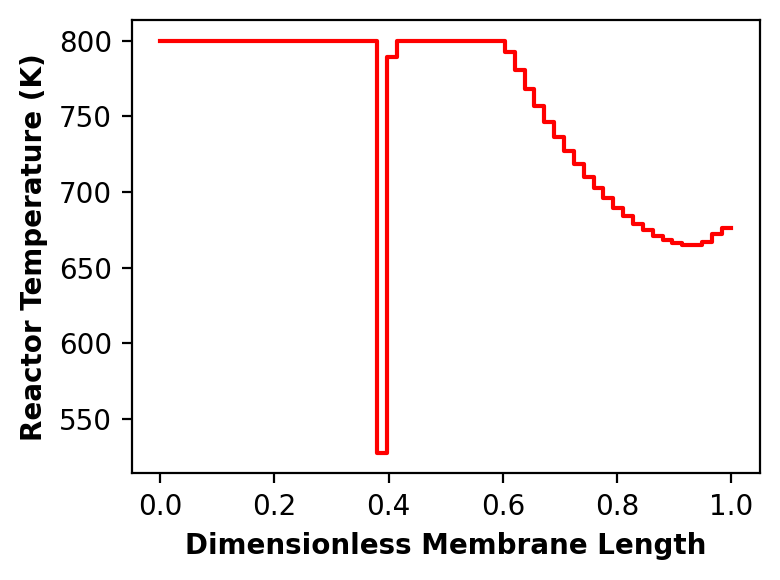

In [8]:
if test_function:
    # plot temperature profile of solution
    temperature_profile(m,line="steps")

In [9]:
temp_optimization = True
T_l = 300
T_u = 800

In [10]:
# optimization without temperature zoning
if temp_optimization:
    # create model instance 
    m = create_model(temp_reactor=623,
                    CO_comp_feed=data['CO_comp_feed'],
                    H2O_comp_feed=data['H2O_comp_feed'],
                    CO2_comp_feed=data['CO2_comp_feed'],
                    H2_comp_feed=data['H2_comp_feed'],
                    CH4_comp_feed=data['CH4_comp_feed'],
                    N2_comp_feed=data['N2_comp_feed'],
                    feed_pressure=data['feed_pressure'],
                    pressure_drop_retentate=data['pressure_drop_retentate'],
                    sweep_pressure=data['sweep_pressure'],
                    pre_exponent=data['pre_exponent'],
                    E_R=data['E_R'],
                    pressure_exponent=data['pressure_exponent'],
                    vol_reactor=data['vol_reactor'],
                    area_membrane=data['area_membrane'],
                    rho_catalyst=data['rho_catalyst'],
                    zoned_temperature=False,
                    Tmax=T_u,
                     Tmin=T_l,
                    num_zones=1)
       
    # solver
    solver = pyo.SolverFactory('ipopt')
    
    # fix ghsv
    R = 8.3145 # J/mol/K
    To = 273 # K
    Po = 101325 # Pa
    ghsv = (3600 * R * To * data['feed_flow'])/(Po * data['vol_reactor'])
    print('\nGHSV =',ghsv,'hr-1')
    
    m.ghsv.fix(ghsv)
    
    toggle_reaction_off(m)
    
    
    # solve
    solver = pyo.SolverFactory("ipopt")
    solver.solve(m,tee=True)
    
    toggle_reaction_on(m)
    init_reaction_rate(m)
    print('Initialization complete')
    solver.solve(m,tee=True)


GHSV = 2831.8562828778227 hr-1
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific


  73 -2.9962831e-01 6.98e-10 1.02e-06  -8.6 7.11e-02  -4.8 1.00e+00 1.00e+00h  1
  74 -2.9963151e-01 6.21e-09 4.57e-06  -8.6 2.12e-01  -5.3 1.00e+00 1.00e+00h  1
  75 -2.9964091e-01 5.41e-08 3.99e-05  -8.6 6.26e-01  -5.8 1.00e+00 1.00e+00h  1
  76 -2.9966730e-01 4.41e-07 3.30e-04  -8.6 1.79e+00  -6.3 5.19e-01 1.00e+00h  1
  77 -2.9973323e-01 3.04e-06 2.34e-03  -8.6 4.73e+00  -6.8 7.28e-01 1.00e+00h  1
  78 -2.9985871e-01 1.46e-05 1.20e-02  -8.6 1.05e+01  -7.2 5.41e-01 1.00e+00h  1
  79 -3.0000848e-01 4.15e-05 3.91e-02  -8.6 1.84e+01  -7.7 9.05e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -3.0011526e-01 7.87e-05 8.88e-02  -8.6 2.70e+01  -8.2 1.00e+00 1.00e+00h  1
  81 -3.0017040e-01 1.29e-04 1.94e-01  -8.6 3.67e+01  -8.7 1.00e+00 1.00e+00h  1
  82 -3.0018023e-01 1.26e-04 2.58e-01  -8.6 5.31e+01  -9.1 1.00e+00 3.48e-01h  1
  83 -3.0018020e-01 1.26e-04 1.53e+00  -8.6 6.47e+01  -9.6 7.41e-01 3.91e-03f  9
  84 -3.0017967e-01 1.23e-05

  27 -2.7775905e-01 3.55e+11 2.34e+10  -1.0 1.95e+01   2.7 1.01e-04 7.22e-03f  1
  28 -2.8168741e-01 3.29e+11 2.08e+10  -1.0 1.94e+01   2.3 2.98e-02 7.13e-02h  1
  29 -2.8322941e-01 3.19e+11 2.01e+10  -1.0 1.80e+01   1.8 3.07e-01 2.85e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -2.8337270e-01 3.19e+11 1.95e+10  -1.0 5.22e+02   1.3 7.96e-04 2.26e-03h  1
  31 -2.8376962e-01 3.16e+11 1.94e+10  -1.0 2.34e+01   1.7 4.29e-02 7.55e-03h  1
  32 -2.8483323e-01 3.10e+11 1.89e+10  -1.0 2.40e+01   1.3 2.51e-02 2.03e-02h  2
  33 -2.8545327e-01 3.06e+11 1.87e+10  -1.0 2.25e+01   1.7 4.34e-01 1.19e-02h  1
  34 -2.8820601e-01 2.89e+11 1.76e+10  -1.0 2.84e+01   1.2 1.71e-01 5.42e-02h  1
  35 -2.8834754e-01 2.89e+11 1.75e+10  -1.0 3.75e+01   1.6 1.42e-01 2.96e-03h  1
  36 -2.8990618e-01 2.79e+11 1.70e+10  -1.0 4.19e+01   1.2 1.83e-01 3.34e-02h  1
  37 -2.8996532e-01 2.78e+11 1.69e+10  -1.0 7.05e+01   1.6 1.20e-01 1.50e-03h  1
  38 -2.9088731e-01 2.71e+11

 122 -4.1710342e-01 1.68e+02 4.47e+01  -5.7 4.92e+01  -6.6 1.00e+00 1.00e+00h  1
 123 -4.1653346e-01 2.84e+01 1.27e+01  -5.7 1.01e+01  -6.1 1.00e+00 1.00e+00h  1
 124 -4.1691695e-01 2.76e+01 3.64e+01  -5.7 1.75e+01  -6.6 1.00e+00 1.00e+00h  1
 125 -4.1741187e-01 3.61e+01 7.37e+01  -5.7 2.00e+01  -7.1 1.00e+00 1.00e+00h  1
 126 -4.1737387e-01 5.39e+00 7.18e+00  -5.7 5.99e+00  -6.7 1.00e+00 1.00e+00h  1
 127 -4.1751604e-01 9.23e+00 2.16e+01  -5.7 1.51e+01  -7.2 1.00e+00 1.00e+00h  1
 128 -4.1772037e-01 8.40e+00 4.88e+01  -5.7 3.31e+01  -7.6 1.00e+00 9.94e-01h  1
 129 -4.1785093e-01 9.47e+01 8.46e+00  -5.7 5.77e+01  -8.1 7.33e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -4.1779772e-01 1.13e+04 4.60e+02  -5.7 1.37e+02  -8.6 3.94e-01 1.00e+00h  1
 131 -4.1778522e-01 1.10e+04 4.45e+02  -5.7 3.88e+00  -4.5 2.54e-01 3.12e-02h  4
 132 -4.1777965e-01 1.08e+04 4.39e+02  -5.7 1.63e+01  -5.0 1.00e+00 1.42e-02h  5
 133 -4.1777453e-01 1.07e+04

In [11]:
if temp_optimization:
    # print hydrogen recovery index
    h2_recovery = pyo.value(m.flow_permeate[m.ELEMENTS.first(),'H2'])/(
        pyo.value(m.flow_retentate[m.ELEMENTS.last(),'H2']) 
        + pyo.value(m.flow_permeate[m.ELEMENTS.first(),'H2'])) * 100
    print('H2 recovery index =',h2_recovery)

H2 recovery index = 95.07407626742874


In [12]:
if temp_optimization:
    # CO conversion
    co_conversion = (1 - pyo.value(m.flow_retentate[m.ELEMENTS.last(),'CO'])/(pyo.value(m.y_feed['CO']))) * 100
    print("CO conversion =",co_conversion)

CO conversion = 99.85444401322195


In [13]:
if temp_optimization:
    # feed utilization efficiency
    # GHSV
    R = 8.3145 # J/mol/K, universal gas constant
    Tstd = 273 # K, standard temperature
    Pstd = 101325 # Pa, standard pressure

    #feed composition 
    feed_composition={'CO':pyo.value(m.y_feed['CO']),
                    'H2O':pyo.value(m.y_feed['H2O']),
                    'CO2':pyo.value(m.y_feed['CO2']),
                    'H2':pyo.value(m.y_feed['H2']),
                    'CH4':pyo.value(m.y_feed['CH4']),
                    'N2':pyo.value(m.y_feed['N2'])}
    vol_reactor = data['vol_reactor']

    # flow conversion from dimensionless flow to mol/s F = F_bar*F0 = F_bar * {Pstd*GHSV*V_H/(3600*R*Tstd)}
    flow_factor = Pstd*pyo.value(m.ghsv)*vol_reactor / (3600*R*Tstd)

    optimal_efficiency = 100*(pyo.value(m.flow_permeate[m.ELEMENTS.first(), "H2"])*flow_factor
                /(flow_factor*feed_composition['H2'] + flow_factor*feed_composition['CO'] + 4*flow_factor*feed_composition['CH4']))
    print("feed utilization efficiency =",optimal_efficiency,"%")

feed utilization efficiency = 80.9695107976495 %


In [14]:
co_conv_std = CO_conversion(m)
h2_rec_std = H2_recovery(m)
feed_efficiency_std=feed_utilization_efficiency(m)
print('CO conversion',co_conv_std)
print('H2 recovery',h2_rec_std)
print('Feed efficiency',feed_efficiency_std)

CO conversion 99.85444401322195
H2 recovery 95.07407626742874
Feed efficiency 80.9695107976495


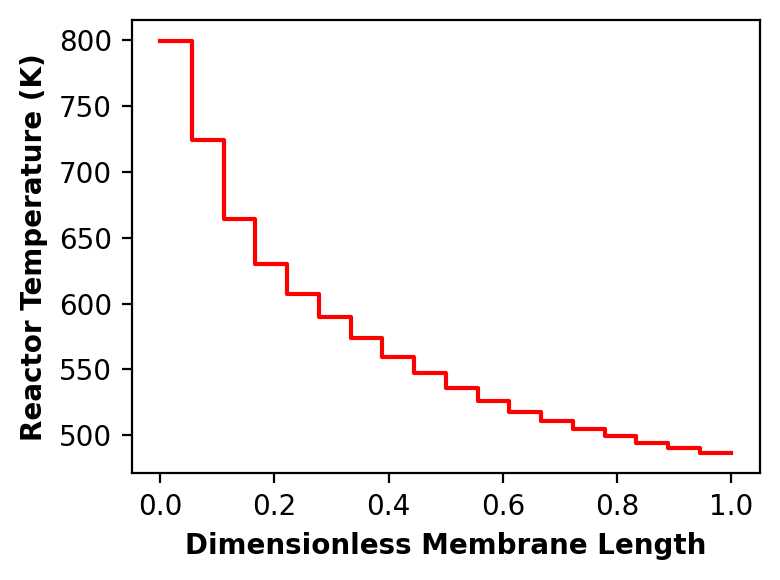

In [15]:
if temp_optimization:
    # plot temperature profile
    temperature_profile(m,line="steps", save_plot=savefig)

In [16]:
# save temperature profile data
if temp_optimization:
    # create container for compositions on both sides
    op_data = {}
    reactor_temp = []

    # loop through membrane module to get composition of each finite element
    for j in m.ELEMENTS:
        if j != m.ELEMENTS.last():  # drop last finite element
            reactor_temp.append(
                pyo.value(m.temp_retentate[j]))
    # xvalues
    xvalues= np.linspace(m.ELEMENTS.first(), 1, m.ELEMENTS.last())
    op_data['length_units']=xvalues
    op_data['{} K'.format(T_u)]=reactor_temp
    
    # simulation conditions
    op_data['T_bounds'] = [T_l,T_u]
    op_data['GHSV'] = [ghsv]
    
    # output
    op_data['conversion'] = [co_conversion]
    op_data['recovery'] = [h2_recovery]
    op_data['efficiency'] = [optimal_efficiency]
    
    # Save
    if savedata:
        profile_pd = pd.DataFrame.from_dict(op_data, orient="index")
        profile_pd.to_csv("output/temperature_profile_optimization_{}.csv".format(T_u))
    

In [17]:
# print variables
if test_function:
    print("GHSV =",pyo.value(m.ghsv))

GHSV = 2831.8562828778227


In [18]:
# plot concentration profile
conc_profile = True
if conc_profile:
    m = create_model(temp_reactor=data['temp_retentate'],
                    CO_comp_feed=data['CO_comp_feed'],
                    H2O_comp_feed=data['H2O_comp_feed'],
                    CO2_comp_feed=data['CO2_comp_feed'],
                    H2_comp_feed=data['H2_comp_feed'],
                    CH4_comp_feed=data['CH4_comp_feed'],
                    N2_comp_feed=data['N2_comp_feed'],
                    feed_pressure=data['feed_pressure'],
                    pressure_drop_retentate=data['pressure_drop_retentate'],
                    sweep_pressure=data['sweep_pressure'],
                    pre_exponent=data['pre_exponent'],
                    E_R=data['E_R'],
                    pressure_exponent=data['pressure_exponent'],
                    vol_reactor=data['vol_reactor'],
                    area_membrane=data['area_membrane'],
                    rho_catalyst=data['rho_catalyst'],
                    zoned_temperature=False,
                    )

    # solver
    solver = pyo.SolverFactory('ipopt')

    # fix ghsv
    m.ghsv.fix(2830)

    # initialize model
    init_model(m,LOUD=True)

    # solve
    solver.solve(m,tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

  85 -4.2159175e-01 8.19e-01 2.63e+15  -1.0 4.37e+00    -  7.65e-09 8.19e-03f  1
  86 -4.2157085e-01 8.14e-01 2.61e+15  -1.0 4.33e+00    -  1.01e-03 6.18e-03f  6
  87 -4.2076859e-01 6.56e-01 2.10e+15  -1.0 4.30e+00    -  7.07e-03 1.94e-01h  1
  88 -4.2067670e-01 6.54e-01 2.10e+15  -1.0 3.47e+00    -  1.59e-01 3.29e-03h  1
  89 -4.2067575e-01 6.54e-01 2.10e+15  -1.0 3.46e+00    -  2.13e-01 3.33e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r-4.2067575e-01 6.54e-01 1.00e+03  -0.2 0.00e+00    -  0.00e+00 1.66e-07R  2
  91r-3.7967513e-01 2.53e-01 1.00e+03  -0.2 1.30e+03    -  4.25e-04 9.90e-04f  1
  92 -3.7967495e-01 2.53e-01 1.60e+05  -1.0 2.27e+00    -  7.54e-01 1.57e-05f  1
  93r-3.7967495e-01 2.53e-01 1.00e+03  -0.6 0.00e+00    -  0.00e+00 2.46e-07R  2
  94r-2.3169387e-01 1.37e-01 9.98e+02  -0.6 1.24e+03    -  1.75e-03 1.52e-03f  1
  95 -2.6451443e-01 8.63e-02 7.75e+04  -1.0 3.94e-01    -  6.92e-01 3.69e-01f  2
  96 -3.0496213e-01 2.93e-02

  15 -2.2204692e-01 3.00e+09 3.93e+05  -1.0 2.29e+01    -  1.00e+00 6.25e-01h  1
  16 -2.2211831e-01 1.15e+09 1.10e+06  -1.0 2.00e+01    -  1.00e+00 6.18e-01h  1
  17 -2.2241001e-01 5.21e+08 2.88e+06  -1.0 6.52e+01    -  1.00e+00 5.46e-01h  1
  18 -2.2388826e-01 2.20e+08 6.16e+06  -1.0 2.28e+02    -  1.00e+00 5.79e-01h  1
  19 -2.2380720e-01 9.42e+07 1.30e+07  -1.0 3.46e+02    -  9.48e-01 5.74e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.2484027e-01 2.64e+07 3.75e+08  -1.0 1.04e+02    -  1.71e-01 7.27e-01f  1
MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 35850 to 71700 and la from 57825 to 116920 and factorize again.
  21 -2.2536544e-01 2.61e+07 3.70e+08  -1.0 1.58e+01   0.2 3.93e-02 1.37e-02h  1
  22 -2.2706598e-01 2.50e+07 3.54e+08  -1.0 1.38e+01   0.7 1.13e-02 4.30e-02f  1
  23 -2.2856411e-01 2.41e+07 3.13e+08  -1.0 1.51e+01   0.2 6.24e-02 3.51e-02f  1
  24 -2.4011319e-01 1.77e+07 9.48e+08  -1.0 1.58e+01  -0

 108 -3.7503897e-01 2.98e-02 1.33e-01  -8.6 4.65e-02  -2.3 9.99e-01 1.00e+00h  1
 109 -3.7510123e-01 2.67e-01 2.20e-04  -8.6 1.39e-01  -2.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.7528733e-01 2.38e+00 4.64e-04  -8.6 4.17e-01  -3.3 1.00e+00 1.00e+00h  1
 111 -3.7583987e-01 2.08e+01 4.01e-03  -8.6 1.24e+00  -3.8 1.00e+00 1.00e+00h  1
 112 -3.7744602e-01 1.70e+02 3.18e-02  -8.6 3.63e+00  -4.2 1.00e+00 1.00e+00h  1
 113 -3.8182253e-01 1.15e+03 2.01e-01  -8.6 1.01e+01  -4.7 1.00e+00 1.00e+00h  1
 114 -3.9163919e-01 4.11e+03 7.16e-01  -8.6 2.35e+01  -5.2 1.00e+00 1.00e+00h  1
 115 -4.0518121e-01 1.02e+03 1.00e+00  -8.6 3.47e+01  -5.7 1.00e+00 1.00e+00h  1
 116 -4.1292516e-01 4.34e+03 1.79e+00  -8.6 1.15e+02  -6.1 8.79e-01 8.90e-01h  1
 117 -4.1250520e-01 3.98e+03 2.38e+00  -8.6 6.35e+01  -6.6 5.62e-01 6.25e-02h  5
 118 -4.1434788e-01 2.77e+03 1.03e+00  -8.6 5.88e+01  -6.2 1.00e+00 6.74e-01h  1
 119 -4.1634700e-01 2.01e+03

 212 -4.1787850e-01 2.17e+00 1.61e+01  -8.6 5.10e+01  -7.8 7.31e-01 1.00e+00h  1
 213 -4.1788252e-01 7.37e-01 5.03e+00  -8.6 2.08e+01    -  1.00e+00 8.10e-01h  1
 214 -4.1788361e-01 7.97e-02 5.73e-01  -8.6 7.51e+00    -  1.00e+00 1.00e+00f  1
 215 -4.1788383e-01 1.11e-03 9.92e-03  -8.6 6.60e-01    -  1.00e+00 1.00e+00h  1
 216 -4.1788383e-01 6.10e-08 5.54e-07  -8.6 1.60e-03    -  1.00e+00 1.00e+00h  1
 217 -4.1788383e-01 1.13e-13 1.46e-11  -8.6 7.17e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 217

                                   (scaled)                 (unscaled)
Objective...............:  -4.1788383343092139e-01   -4.1788383343092139e-01
Dual infeasibility......:   1.4624362888312537e-11    1.4624362888312537e-11
Constraint violation....:   1.5092094240998222e-16    1.1279865930191590e-13
Complementarity.........:   2.5059035596802843e-09    2.5059035596802843e-09
Overall NLP error.......:   2.5059035596802843e-09    2.5059035596802843e-09


Number of objective func

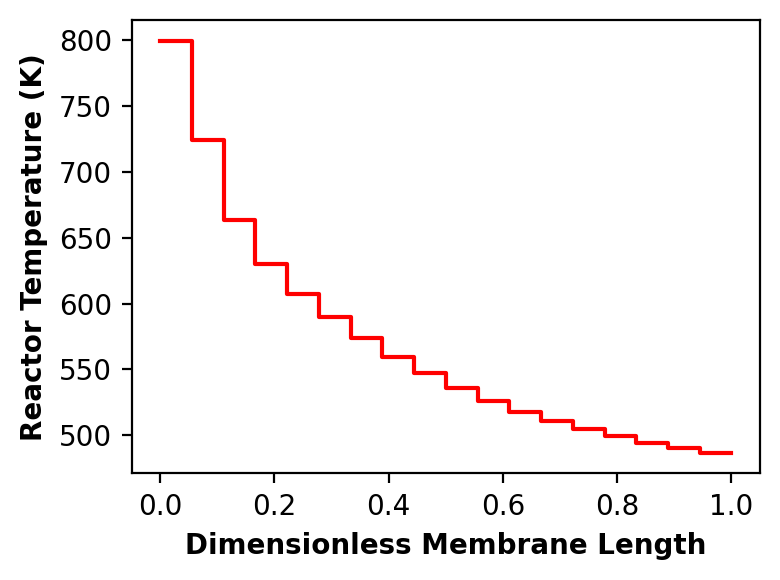

In [19]:
if conc_profile:
    # plot temperature profile
    temperature_profile(m,line="steps", save_plot=savefig)

In [20]:
def zoned_temperature_sensitivity(num_elements=100,
                                   T_max_list = [400,600,800],
                                  num_stages_list = np.arange(1,10),
                                  fix_ghsv=True,
                                  new_model_each_iter=True,
                                  LOUD=False,
                                  save_data=False,
                                 ):
    '''
    Sensitivity analysis for temperature profile optimization in a staged WGS-MR
    
    Arguments:
        num_elements: int, total number of finite volumes in the reactor,
        T_max_list: list of floats, reactor temperature upper bounds
        num_stages_list: list, list of number of stages
        fix_ghsv: bool, if True fix GHSV
        new_model_each_iter: bool, if True create new model each iteration
        LoUD: bool, if True, print
        save_data: bool, if True, save output data
    '''
    # data
    vol_reactor=data['vol_reactor']
    feed_composition={'CO':data['CO_comp_feed'],
    'H2O':data['H2O_comp_feed'],
    'CO2':data['CO2_comp_feed'],
    'H2':data['H2_comp_feed'],
    'CH4':data['CH4_comp_feed'],
    'N2':data['N2_comp_feed']}
    molar_masses={'CO':28.01,
    'H2O':18.015,
    'CO2':44.01,
    'H2':2.016,
    'CH4':16.04,
    'N2':28.014}
    LOUD=True

    # define constants
    R = 8.3145 # J/mol/K, universal gas constant
    Tstd = 273 # K, standard temperature
    Pstd = 101325 # Pa, standard pressure
    
    # GHSV
    GHSV = (3600 * R * Tstd * data['feed_flow'])/(Pstd * data['vol_reactor'])
    # print input
    if LOUD:
        print("\nGHSV=",GHSV)


    # calculate volumetric flow from GHSV
    volumetric_flow = GHSV*vol_reactor/3600 # divide by 3600 to convert from hr-1 to s-1
    # calculate molar flow from ideal gas law (Pv = nRT) at STP (25 C, 1 atm)
    feed = Pstd*volumetric_flow/(R*Tstd)

    # convert feed flow rate to kg basis
    mixture_MM = sum(feed_composition[comp]*molar_masses[comp] for comp in feed_composition) # feed gas MM
    kg_feed = feed*mixture_MM/1000 # feed gas mass fow rate, divide by 1000 to convert from g to kg

    # dictionary to hold results
    kg_H2_dict = {'Number of Stages':num_stages_list}
    conversion_dict = {'Number of Stages':num_stages_list}
    recovery_dict = {'Number of Stages':num_stages_list}
    status_dict = {}
    
    # Add theoretical maximum 
    # kg H2 in feed = y_H2 in feed * F_feed * MM_H2/1000
    kg_H2_feed = data['H2_comp_feed'] * feed * molar_masses['H2']/1000
    # kg H2 from WGS = y_CO in feed * F_feed * MM_H2/1000
    kg_H2_WGS = data['CO_comp_feed'] * feed * molar_masses['H2']/1000
    # Theoretical max = (kg H2 in feed + kg H2 from WGS)/(kg feed)
    

    # loop through Tmax list
    for temp in T_max_list:

        # dictionary to store models
        model_dict = {}
        
        # make list to hold results
        kg_H2_list = np.zeros(len(num_stages_list))
        H2_rec_list = np.zeros(len(num_stages_list))
        conversion_list = np.zeros(len(num_stages_list))
        status_list = np.zeros(len(num_stages_list))

        # loop through number of stages:
        for i, num in enumerate(num_stages_list):

            print("\n\n*************Begin calculations for",num,"-staged reactor*************")

            # create model
            # if first iter or model_routine = create
            if (i==0 or new_model_each_iter):
                m = create_model(temp_reactor=temp,
                                CO_comp_feed=data['CO_comp_feed'],
                                H2O_comp_feed=data['H2O_comp_feed'],
                                CO2_comp_feed=data['CO2_comp_feed'],
                                H2_comp_feed=data['H2_comp_feed'],
                                CH4_comp_feed=data['CH4_comp_feed'],
                                N2_comp_feed=data['N2_comp_feed'],
                                feed_pressure=data['feed_pressure'],
                                pressure_drop_retentate=data['pressure_drop_retentate'],
                                sweep_pressure=data['sweep_pressure'],
                                pre_exponent=data['pre_exponent'],
                                E_R=data['E_R'],
                                pressure_exponent=data['pressure_exponent'],
                                vol_reactor=data['vol_reactor'],
                                area_membrane=data['area_membrane'],
                                rho_catalyst=data['rho_catalyst'],
                                Tmax=temp,
                                zoned_temperature=True,
                                num_zones=num,
                                num_elements=num_elements)
            else:
                # update model
                update_zoned_temp_constraint(m,num)
            # fix ghsv
            if fix_ghsv:
                m.ghsv.fix(GHSV)

            # initialize model
            if i == 0:
                print('initializing model_ _ _ _ _ _ _  _ _ _ _ _')
                init_model(m,LOUD=LOUD)
                    
            else:
                print('\n\ninitializing model_ _ _ _ _ _ _  _ _ _ _ _\n')
                # set update flag (0 to skip, 1 to update with previous solution)
                update_flag = 0
                
                # set best obj value
                best_obj_val = pyo.value(m.OBJ)
                best_obj_index = 1 # or first key in a dictionary
                
                # check if better solution exists with number of zones >1
                
                for stage_number in model_dict.keys():
                    
                    # find number of zones that is a factor of current number of zones
                    if num % int(stage_number) == 0:
                        
                        # if objective value is better than the previous:
                        if pyo.value(model_dict["{}".format(stage_number)].OBJ) >= best_obj_val:
                            
                            # update the best objective
                            best_obj_val = pyo.value(model_dict["{}".format(stage_number)].OBJ)
                            best_obj_index = stage_number
                            update_flag = 1
                        else:
                            pass
                    else:
                        pass
                
                # if a solution exists from a zone that is a factor of current zone
                # initialize with it. Else, initialize with single-zone model
                if update_flag == 0:
                    reference_model = model_dict['1']
                elif update_flag == 1:
                    reference_model = model_dict['{}'.format(best_obj_index)]
                print('\n*****updating model with {} zones using model with {} zones'.format(num,best_obj_index))
                
                init_model(m,init_level=1, ref=reference_model,LOUD=LOUD)



            # solver
            model_solver = pyo.SolverFactory("ipopt")

            # solve model
            results = model_solver.solve(m, tee=LOUD)
            
            
            # store model
            model_dict["{}".format(num)] = m.clone()
            
            # feed utilization efficiency
            feed_efficiency = feed_utilization_efficiency(m)
            kg_H2_list[i] = int(feed_efficiency)
            # CO conversion
            CO_conv = CO_conversion(m)
            conversion_list[i] = int(CO_conv)
            # H2 recovery
            H2_rec = H2_recovery(m)
            H2_rec_list[i] = int(H2_rec)
            print('__________________________________________________\n')
        kg_H2_dict["$T^u$ = {} K".format(temp)] = kg_H2_list
        conversion_dict["$T^u$ = {} K".format(temp)] = conversion_list
        recovery_dict["$T^u$ = {} K".format(temp)] = H2_rec_list


    # convert dictionaries to a pd
    kg_H2_pd = pd.DataFrame.from_dict(kg_H2_dict, orient="index")
    kg_H2_pd = kg_H2_pd.transpose()
    conversion_pd = pd.DataFrame.from_dict(conversion_dict, orient='index')
    conversion_pd = conversion_pd.transpose()
    recovery_pd = pd.DataFrame.from_dict(recovery_dict, orient='index')
    recovery_pd = recovery_pd.transpose()
    
    # save data
    if savedata:
        kg_H2_pd.to_csv('output/zoned_temperature_optimization_{}.csv'.format(case))
        conversion_pd.to_csv('output/zoned_temperature_optimization_conversion.csv')
        
    
    return kg_H2_pd, conversion_pd, recovery_pd
    

In [21]:
def plot_pd_modified(file_path=None, data=None, x_label=None, y_label=None, y_lim=[], txt=None, txt_loc=None, legend_loc=(0.5, 1), show_legend=True, legend_col=3, y_ticks=None, x_ticks=None, save_fig=False):
    '''
    Function to plot pandas dataframe
    
    arguments:
        file_path: str, path to csv file containing data
        data: Pandas dataftrame, conversion vs sweep data to be plotted
        y_label: str [optional], label for y-axis.
        y_lim: list [optional], limits for y-axis
        txt: str, text to print inside plot, e.g key simulatin paraters
        txt_loc: list, specify x,y location to begin text,
        show_legend: bool, if True show legend
        legend_loc: list, coordinates for legend location, specify as fraction
        legend_col: int, number of columns for legend
        y_ticks: list, specify yticks
        x_ticks: list, specify xticks
        save_fig: boolean, "True" to save figure
    
    returns:
        fig: plot object
        
    Others:
        This function assumes that the first column in the pandas dataframe provided contains x values
        
    '''
    # load data
    if file_path:
        data_pd = pd.read_csv(file_path)
    elif not data.empty:
        data_pd = data
    else:
        raise ValueError("data input missing, provide file_path (path to .csv file) or data_pd (Pandas dataframe)")
        
    # clean data: if pd has an arbitrary unnamed column, drop!
    if "Unnamed: 0" in data_pd.columns:
        data_pd.drop(columns="Unnamed: 0", inplace=True)
    
    # set matplotlib parameters
    fig = plt.figure(figsize=(4,3),dpi=200)
    plt.rcParams.update({"font.size": 10, "axes.labelweight":"bold"})
    
    # create list of line styles
    line_styles = ["k*-","bo-","mx--","g+-","yp-","r:",]
    
    # loop through dataframe columns to plot conversions
    for i,col in enumerate(data_pd.columns):
        if i >0: # drop first column (column of x values)
            plt.plot(data_pd[data_pd.columns[0]],data_pd[col], line_styles[i-1], label=col, markersize=4)
            plt.xlabel(data_pd.columns[0])
    if y_label:
        plt.ylabel(y_label)
        
    if x_label:
        plt.xlabel(x_label)
    # specify yticks
    if not y_ticks==[]:
        plt.yticks(y_ticks)
    
    # specify xticks
    if not x_ticks==[]:
        plt.xticks(x_ticks)
    
    # y limits
    if not y_lim == []:
        plt.ylim(y_lim[0],y_lim[1])
        
    if show_legend:
        plt.legend(loc="lower center", fontsize=10, bbox_to_anchor=legend_loc, ncol=legend_col)
    # add text to plot
    if not txt is None:
        plt.text(txt_loc[0], txt_loc[1], txt, fontsize=8)
    fig.tight_layout()
    
    
    # save plot to png
    if save_fig:
        # name plot
        if not y_label:
            plot_name = "plot" + data_pd.columns[0]
        plot_name = y_label + " vs " + data_pd.columns[0] + " plot"
        
        # save plot
        plt.savefig("output/{}.png".format(plot_name))
        plt.savefig("output/{}.pdf".format(plot_name))
    return fig
    

CASE 2: Create model first time with initialization and update subsequently, fix GHSV

In [22]:

kgH2_pd2, conversion, recovery = zoned_temperature_sensitivity(num_elements=60,
                                         num_stages_list = np.arange(1,5),
                                        T_max_list = [400,600],
                                          fix_ghsv=True,
                                          new_model_each_iter=False,
                                              LOUD=False) # np.arange(1,11), [800,600,400]



GHSV= 2831.8562828778227


*************Begin calculations for 1 -staged reactor*************
elements per zone = 60
zone end elements = [59]
temp_retentate[58] ==  temp_retentate[59]
temp_retentate[57] ==  temp_retentate[59]
temp_retentate[56] ==  temp_retentate[59]
temp_retentate[55] ==  temp_retentate[59]
temp_retentate[54] ==  temp_retentate[59]
temp_retentate[53] ==  temp_retentate[59]
temp_retentate[52] ==  temp_retentate[59]
temp_retentate[51] ==  temp_retentate[59]
temp_retentate[50] ==  temp_retentate[59]
temp_retentate[49] ==  temp_retentate[59]
temp_retentate[48] ==  temp_retentate[59]
temp_retentate[47] ==  temp_retentate[59]
temp_retentate[46] ==  temp_retentate[59]
temp_retentate[45] ==  temp_retentate[59]
temp_retentate[44] ==  temp_retentate[59]
temp_retentate[43] ==  temp_retentate[59]
temp_retentate[42] ==  temp_retentate[59]
temp_retentate[41] ==  temp_retentate[59]
temp_retentate[40] ==  temp_retentate[59]
temp_retentate[39] ==  temp_retentate[59]
temp_retentate[38

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-4.9584398e-01 1.82e+02 1.00e+03   2.3 0.00e+00    -  0.00e+00 3.88e-07R  2
  51r-4.9439920e-01 4.33e+01 6.34e+02   2.3 1.30e+06    -  6.71e-01 1.46e-03f  1
  52 -4.9452719e-01 4.33e+01 3.22e+02  -1.0 1.49e+03    -  2.02e-01 8.08e-04f  1
  53r-4.9452719e-01 4.33e+01 9.99e+02   1.6 0.00e+00    -  0.00e+00 2.61e-07R  6
  54r-4.8981769e-01 1.10e+01 9.98e+02   1.6 9.92e+05    -  5.58e-04 1.11e-03f  1
  55 -4.8989122e-01 1.10e+01 5.79e+02  -1.0 3.86e+02    -  2.07e-01 4.63e-04h  1
  56 -4.8988081e-01 1.10e+01 4.29e+06  -1.0 3.86e+02    -  5.38e-01 7.28e-05h  1
  57 -4.8972310e-01 1.10e+01 2.22e+09  -1.0 3.86e+02    -  5.05e-01 9.64e-04h  1
  58r-4.8972310e-01 1.10e+01 1.00e+03   1.0 0.00e+00    -  0.00e+00 3.01e-07R  6
  59r-4.7140530e-01 2.76e+00 9.87e+02   1.0 2.87e+05    -  3.31e-01 1.00e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -4.7141106e-01 2.76e+00

 142 -2.9415522e-01 7.67e-09 5.55e+03  -2.5 6.30e-02    -  1.00e+00 1.00e+00h  1
 143 -2.9434444e-01 6.72e-07 6.25e+03  -3.8 8.27e-01    -  1.00e+00 1.00e+00h  1
 144 -2.9713642e-01 1.54e-04 5.71e+02  -3.8 1.26e+01    -  1.00e+00 1.00e+00h  1
 145 -2.9651168e-01 1.72e-06 8.28e+01  -3.8 5.77e-01    -  1.00e+00 1.00e+00h  1
 146 -2.9650056e-01 3.52e-10 7.95e-02  -3.8 1.90e-02    -  1.00e+00 1.00e+00h  1
 147 -2.9801967e-01 9.45e-05 3.16e+03  -8.6 1.06e+01    -  7.95e-01 1.00e+00f  1
 148 -2.9941622e-01 2.32e-04 7.68e+02  -8.6 1.80e+01    -  9.82e-01 1.00e+00h  1
 149 -2.9984583e-01 2.26e-04 2.04e+02  -8.6 2.02e+01    -  9.98e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -2.9984050e-01 4.05e-05 1.82e+01  -8.6 9.99e+00    -  1.00e+00 9.94e-01h  1
 151 -2.9983405e-01 2.03e-05 8.96e+00  -8.6 1.08e-02    -  9.75e-01 5.00e-01h  2
 152 -2.9982757e-01 2.01e-08 1.45e-01  -8.6 5.08e-03    -  1.00e+00 1.00e+00h  1
 153 -2.9982756e-01 3.10e-10

__________________________________________________



*************Begin calculations for 2 -staged reactor*************
elements per zone = 30
zone end elements = [29, 59]
temp_retentate[28] ==  399.9998638004815
temp_retentate[27] ==  399.9998638004815
temp_retentate[26] ==  399.9998638004815
temp_retentate[25] ==  399.9998638004815
temp_retentate[24] ==  399.9998638004815
temp_retentate[23] ==  399.9998638004815
temp_retentate[22] ==  399.9998638004815
temp_retentate[21] ==  399.9998638004815
temp_retentate[20] ==  399.9998638004815
temp_retentate[19] ==  399.9998638004815
temp_retentate[18] ==  399.9998638004815
temp_retentate[17] ==  399.9998638004815
temp_retentate[16] ==  399.9998638004815
temp_retentate[15] ==  399.9998638004815
temp_retentate[14] ==  399.9998638004815
temp_retentate[13] ==  399.9998638004815
temp_retentate[12] ==  399.9998638004815
temp_retentate[11] ==  399.9998638004815
temp_retentate[10] ==  399.9998638004815
temp_retentate[9] ==  399.9998638004815
temp_ret

  47 -1.6821317e-01 4.47e+08 8.32e+07  -1.0 5.93e+00    -  7.23e-02 2.51e-02h  1
  48 -1.6819419e-01 4.14e+08 8.49e+07  -1.0 5.78e+00    -  1.29e-01 7.32e-02h  1
  49 -1.6815688e-01 3.49e+08 4.53e+07  -1.0 5.36e+00    -  5.07e-01 1.57e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.6809817e-01 2.48e+08 1.97e+07  -1.0 4.52e+00    -  6.06e-01 2.91e-01h  1
  51 -1.6800369e-01 9.05e+07 5.20e+06  -1.0 3.20e+00    -  8.22e-01 6.34e-01h  1
  52 -1.6796054e-01 6.25e+06 2.71e+07  -1.0 1.17e+00    -  1.51e-01 9.29e-01h  1
  53 -1.6787744e-01 4.74e+06 1.98e+07  -1.7 7.96e+00    -  1.19e-01 2.40e-01h  1
  54 -1.6779192e-01 3.11e+06 8.97e+06  -1.7 9.61e+00    -  2.44e-01 3.40e-01h  1
  55 -1.6779061e-01 3.10e+06 9.03e+06  -1.7 1.93e+01    -  3.42e-02 2.50e-03h  1
  56 -1.6799939e-01 2.86e+06 7.78e+06  -1.7 2.06e+01    -  4.68e-02 7.86e-02h  1
  57 -1.6894239e-01 2.13e+06 5.73e+06  -1.7 2.96e+01    -  9.59e-02 2.50e-01h  1
  58 -1.7059815e-01 1.58e+06

 147 -2.3798634e-01 8.19e+04 2.93e+05  -2.5 1.18e+02    -  2.88e-03 1.42e-04h  1
 148 -2.3803492e-01 8.19e+04 8.97e+05  -2.5 1.18e+02    -  5.57e-03 4.31e-04f  2
 149 -2.3808345e-01 8.18e+04 1.33e+06  -2.5 1.18e+02    -  1.73e-03 4.31e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r-2.3808345e-01 8.18e+04 1.00e+03  -2.3 0.00e+00    -  0.00e+00 3.00e-07R  6
 151r-2.4663781e-01 8.10e+04 1.05e+03  -2.3 4.73e+00    -  6.58e-03 3.73e-03f  1
 152r-2.5187706e-01 7.90e+04 1.07e+03  -2.3 3.01e+00    -  4.20e-03 2.60e-03f  1
 153r-2.5380775e-01 7.81e+04 1.08e+03  -2.3 3.09e+00    -  1.31e-03 1.15e-03f  1
 154r-2.6772098e-01 7.13e+04 1.04e+03  -2.3 3.14e+00    -  6.55e-03 8.45e-03f  1
 155r-2.7233121e-01 6.71e+04 1.11e+03  -2.3 3.21e+00    -  1.20e-02 5.16e-03f  1
 156r-2.7517196e-01 6.28e+04 1.17e+03  -2.3 2.35e+00    -  1.64e-02 7.42e-03f  1
 157r-2.7762805e-01 5.80e+04 1.16e+03  -2.3 9.78e-01    -  1.44e-02 1.56e-02f  1
 158r-2.7996854e-01 5.51e+04

  16 -1.7108498e-01 1.31e+10 1.14e+06  -1.0 2.07e+02    -  6.30e-02 4.09e-02h  1
  17 -1.7008494e-01 9.92e+09 8.82e+05  -1.0 1.99e+02    -  2.82e-01 2.45e-01h  1
  18 -1.7005770e-01 9.85e+09 8.76e+05  -1.0 1.50e+02    -  6.45e-02 6.78e-03h  1
  19 -1.6905868e-01 6.97e+09 6.38e+05  -1.0 1.49e+02    -  2.12e-01 2.93e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.6903504e-01 6.87e+09 6.27e+05  -1.0 1.05e+02    -  1.40e-01 1.41e-02h  1
  21 -1.6888772e-01 6.11e+09 9.99e+05  -1.0 1.04e+02    -  2.28e-01 1.12e-01h  1
  22 -1.6884861e-01 5.91e+09 9.12e+05  -1.0 9.24e+01    -  3.10e-02 3.22e-02h  1
  23 -1.6882123e-01 5.76e+09 8.86e+05  -1.0 8.94e+01    -  2.49e-02 2.50e-02h  1
  24 -1.6879379e-01 5.59e+09 8.36e+05  -1.0 8.72e+01    -  2.82e-02 2.93e-02h  1
  25 -1.6875881e-01 5.31e+09 1.46e+06  -1.0 8.46e+01    -  4.53e-02 5.10e-02h  1
  26 -1.6869847e-01 4.71e+09 1.47e+06  -1.0 8.03e+01    -  2.70e-02 1.13e-01h  1
  27 -1.6859116e-01 3.59e+09

 122 -3.2492538e-01 4.82e+03 1.37e+06  -1.7 2.23e+01    -  1.00e+00 6.25e-02h  5
 123 -3.2486022e-01 4.63e+03 1.30e+06  -1.7 1.99e+01    -  9.32e-01 6.25e-02h  5
 124 -3.2423306e-01 9.95e+03 7.63e+05  -1.7 2.02e+01    -  1.00e+00 1.00e+00w  1
 125 -3.2576615e-01 4.40e+03 1.38e+05  -1.7 7.86e+00    -  1.00e+00 1.00e+00w  1
 126 -3.2595827e-01 1.10e+02 7.73e+03  -2.5 5.81e-01    -  1.00e+00 1.00e+00h  1
 127 -3.2792063e-01 1.78e+02 5.40e+02  -2.5 3.72e+00    -  1.00e+00 1.00e+00h  1
 128 -3.2977675e-01 2.02e+02 1.54e+04  -3.8 3.00e+00    -  9.48e-01 1.00e+00h  1
 129 -3.2981300e-01 6.86e-02 1.54e+00  -3.8 8.74e-05   1.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.3789789e-01 4.51e+03 4.60e+02  -5.7 2.56e+02    -  8.96e-02 9.88e-02f  1
 131 -3.4866637e-01 7.58e+03 4.72e+03  -5.7 5.87e+01    -  2.78e-01 5.74e-01f  1
 132 -3.5197179e-01 5.58e+03 1.09e+03  -5.7 2.84e+01    -  5.55e-01 3.77e-01h  1
 133 -3.5652125e-01 3.41e+02

  15 -1.6936195e-01 1.43e+09 3.58e+05  -1.0 1.24e+02    -  5.36e-01 7.69e-01h  1
  16 -1.6948609e-01 1.14e+09 5.59e+06  -1.0 2.87e+01    -  1.00e+00 1.99e-01h  1
  17 -1.6918778e-01 1.47e+08 1.22e+06  -1.0 2.29e+01    -  1.00e+00 8.71e-01h  1
  18 -1.6932637e-01 1.08e+08 3.41e+07  -1.0 2.95e+00    -  1.00e+00 2.63e-01h  1
  19 -1.6923088e-01 3.45e+07 2.53e+07  -1.0 2.17e+00    -  1.00e+00 6.81e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.6947703e-01 1.94e+07 2.46e+07  -1.0 2.31e+00    -  9.53e-01 4.39e-01h  1
  21 -1.6975948e-01 1.36e+07 1.19e+08  -1.0 3.65e+00    -  4.86e-01 2.97e-01h  1
  22 -1.6987100e-01 1.18e+07 4.10e+08  -1.0 2.72e+00    -  2.26e-02 1.33e-01h  1
  23r-1.6987100e-01 1.18e+07 1.00e+03   0.2 0.00e+00   8.0 0.00e+00 3.04e-07R  4
  24r-1.6707770e-01 7.79e+06 1.00e+03   0.2 3.61e+03    -  1.42e-03 1.09e-03f  1
  25 -1.6707888e-01 7.78e+06 3.55e+04  -1.0 5.25e+00    -  5.01e-01 9.90e-05h  1
  26 -1.6752536e-01 7.51e+06

 111 -2.0033308e-01 1.72e+05 9.38e+07  -1.7 7.80e+01    -  9.08e-03 1.48e-04h  1
 112 -2.0031667e-01 1.72e+05 9.34e+07  -1.7 7.15e+01    -  1.57e-02 1.40e-03f  3
 113 -2.0043488e-01 1.71e+05 8.60e+07  -1.7 1.92e+01    -  3.18e-02 8.57e-03h  1
 114 -2.0097580e-01 1.66e+05 5.37e+07  -1.7 8.09e+00    -  4.21e-04 2.52e-02f  1
 115 -2.0098633e-01 1.66e+05 5.37e+07  -1.7 2.81e+02    -  8.63e-04 2.66e-04h  2
 116 -2.0100110e-01 1.66e+05 5.36e+07  -1.7 3.42e+02    -  1.26e-03 3.50e-04h  1
 117 -2.0100389e-01 1.66e+05 5.36e+07  -1.7 5.32e+02    -  6.41e-03 5.52e-05h  1
 118 -2.0176922e-01 1.25e+05 4.76e+07  -1.7 5.45e+02    -  9.81e-03 1.50e-02h  1
 119 -2.0022569e-01 1.25e+05 4.70e+07  -1.7 6.65e+02    -  3.56e-03 9.74e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -2.0011468e-01 1.25e+05 4.70e+07  -1.7 5.70e+02    -  6.51e-05 5.19e-04f  3
 121 -1.9998484e-01 1.25e+05 4.71e+07  -1.7 4.55e+02    -  1.00e-01 7.48e-04h  1
 122 -1.9927652e-01 1.20e+05

MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 111715 to 223430 and la from 177500 to 358918 and factorize again.
 226 -3.2562246e-01 4.67e+04 2.93e+03  -3.8 2.41e+01    -  6.55e-01 1.00e+00H  1
 227 -3.3460976e-01 2.45e+04 1.80e+03  -3.8 4.14e+01    -  5.83e-01 1.00e+00H  1
 228 -3.4576306e-01 7.38e+03 7.75e+02  -3.8 8.36e+00    -  3.65e-01 1.00e+00h  1
 229 -3.4619128e-01 2.06e+04 4.11e+02  -3.8 2.06e+01    -  6.27e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -3.4504577e-01 5.06e+02 1.25e+11  -3.8 3.95e-03  12.3 1.00e+00 1.00e+00h  1
 231 -3.4504050e-01 2.15e-01 1.70e+09  -3.8 5.45e-05  11.8 1.00e+00 1.00e+00h  1
MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 223430 to 446860 and la from 358918 to 729836 and factorize again.
 232 -3.4504050e-01 2.45e-08 3.01e+03  -3.8 1.40e-08  11.3 1.00e+00 1.00e+00h  1
 233 -3.4504050e-01 3.10e-10 1.12e+01  -3.8 1.57e-10  10.9 1.00e+00 1.00e+00  

  25 -4.9872635e-01 3.44e+03 3.53e+00  -1.0 1.47e+04    -  2.16e-02 9.85e-02h  1
  26 -4.9889243e-01 3.44e+03 2.23e+02  -1.0 1.32e+04    -  1.69e-01 1.17e-03h  1
  27 -4.9884938e-01 3.44e+03 3.19e+05  -1.0 1.32e+04    -  3.72e-01 2.71e-04h  1
  28 -4.9723008e-01 3.41e+03 8.07e+06  -1.0 1.32e+04    -  2.39e-01 9.38e-03h  1
  29 -4.9721388e-01 3.41e+03 2.05e+10  -1.0 1.31e+04    -  2.49e-01 9.48e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-4.9721388e-01 3.41e+03 1.00e+03   3.5 0.00e+00    -  0.00e+00 4.74e-07R  2
  31r-4.1475463e-01 1.54e+03 1.39e+03   3.5 7.23e+05    -  3.61e-02 3.60e-03f  1
  32 -4.2209550e-01 1.47e+03 4.74e+00  -1.0 1.05e+04    -  8.24e-03 4.76e-02h  1
  33 -4.2216736e-01 1.47e+03 5.53e+02  -1.0 9.98e+03    -  1.75e-01 5.16e-04h  1
  34 -4.2216639e-01 1.47e+03 2.63e+06  -1.0 9.98e+03    -  1.09e-01 2.28e-05h  1
  35 -4.2213533e-01 1.47e+03 3.93e+09  -1.0 9.98e+03    -  4.98e-01 3.24e-04h  1
  36r-4.2213533e-01 1.47e+03

 123 -3.0086540e-01 3.71e-05 4.70e+05  -1.7 1.13e+01    -  9.90e-01 9.41e-01h  1
 124 -3.0054886e-01 1.41e-06 7.67e+03  -1.7 2.17e+00    -  1.00e+00 9.92e-01h  1
 125 -3.0039059e-01 3.51e-07 5.79e+03  -2.5 1.05e+00    -  1.00e+00 1.00e+00h  1
 126 -3.0031137e-01 2.46e-07 1.00e+03  -2.5 1.37e+00    -  1.00e+00 1.00e+00h  1
 127 -3.0025826e-01 9.19e-07 1.28e+04  -3.8 2.59e+00    -  1.00e+00 1.00e+00H  1
 128 -3.0024836e-01 2.82e-07 9.39e+02  -3.8 2.66e+00    -  1.00e+00 1.00e+00H  1
 129 -3.0024724e-01 1.16e-07 3.46e+02  -3.8 9.63e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -3.0024725e-01 2.16e-06 4.88e+02  -5.7 1.24e+00    -  1.00e+00 1.00e+00H  1
 131 -3.0024822e-01 1.62e-07 1.18e+02  -5.7 1.58e+00    -  8.68e-01 1.00e+00H  1
MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 201210 to 402420 and la from 353434 to 713294 and factorize again.
 132 -3.0024881e-01 2.27e-07 2.24e+01  -8.6 1.36e+00 


Initialization completed


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.1781038e-01 3.10e-10 1.89e-10  -8.6 2.29e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:  -4.1781038197985559e-01   -4.1781038197985559e-01
Dual infeasibility......:   1.8924734562871476e-10    1.8924734562871476e-10
Constraint violation....:   3.1047875381773338e-10    3.1047875381773338e-10
Complementarity.........:   2.5059035596800709e-09    2.5059035596800709e-09
Overall NLP error.......:   2.5059035596800709e-09    2.5059035596800709e-09


Number of objective function evaluations             = 79
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 79
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 71
Number of inequality constraint Jacobian evaluations = 0
Num

MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 111765 to 223530 and la from 177605 to 370726 and factorize again.
  29 -4.1420226e-01 2.15e+03 3.01e+10  -2.5 4.04e-01   5.3 1.09e-01 1.15e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -4.1552360e-01 1.29e+03 5.12e+10  -2.5 5.98e-02   4.8 7.75e-02 4.00e-01h  1
  31 -4.1715588e-01 3.25e+02 4.06e+10  -2.5 1.09e-01   4.3 5.53e-01 7.50e-01h  1
  32 -4.1781378e-01 9.43e-01 9.91e+09  -2.5 5.31e-02   3.8 8.45e-01 1.00e+00h  1
  33 -4.1782163e-01 2.29e-04 8.64e+07  -2.5 1.06e-04   3.4 1.00e+00 1.00e+00h  1
  34 -4.1782163e-01 3.10e-10 2.41e+01  -2.5 9.88e-07   2.9 1.00e+00 1.00e+00h  1
  35 -4.1782163e-01 3.10e-10 6.06e-04  -8.6 4.59e-10   2.4 1.00e+00 1.00e+00h  1
  36 -4.1786767e-01 9.91e+00 3.03e-01  -8.6 5.74e+01    -  1.00e+00 2.60e-01h  1
  37 -4.1789009e-01 8.87e+00 3.69e+00  -8.6 2.84e+01    -  1.00e+00 2.79e-01f  1
  38 -4.1788843e-01 7.82e+00 1.89e+00  -8.6 8.54e+00 

  12 -3.9875781e-01 2.65e+09 3.88e+15  -1.0 1.31e+04    -  9.65e-01 1.77e-05h  1
  13 -4.5000253e-01 1.72e+09 3.01e+15  -1.0 1.31e+04    -  2.14e-01 3.30e-01h  1
  14r-4.5000253e-01 1.72e+09 1.00e+03   4.7 0.00e+00    -  0.00e+00 1.10e-07R  2
  15r-4.5415897e-01 1.72e+09 7.41e+04   4.7 5.37e+06    -  1.08e-02 4.16e-05f  1
  16r-4.5459556e-01 1.40e+09 7.33e+04   2.6 4.86e+06    -  3.91e-02 1.13e-02f  1
  17 -4.5807798e-01 1.36e+09 2.37e+01  -1.0 7.18e+02    -  5.18e-01 3.17e-02h  1
  18 -4.5909037e-01 1.31e+09 4.64e+02  -1.0 6.95e+02    -  7.42e-01 3.31e-02h  1
  19 -4.5920510e-01 1.19e+09 3.97e+02  -1.0 6.72e+02    -  6.08e-02 9.59e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -4.5919184e-01 1.19e+09 2.27e+04  -1.0 6.08e+02    -  7.28e-01 1.42e-03h  1
  21 -4.6331883e-01 1.18e+09 5.91e+05  -1.0 6.07e+02    -  4.63e-02 1.57e-03h  1
  22 -4.6336025e-01 1.18e+09 5.97e+08  -1.0 6.06e+02    -  1.74e-01 3.65e-05h  1
  23 -4.6336319e-01 1.18e+09

 105 -2.9583133e-01 2.44e+07 1.89e+02  -1.0 9.52e+01    -  4.87e-04 1.29e-05f  2
 106 -2.9583116e-01 2.44e+07 1.62e+03  -1.0 8.71e+01    -  1.39e-04 1.67e-05h  1
 107r-2.9583116e-01 2.44e+07 9.99e+02   0.6 0.00e+00    -  0.00e+00 2.65e-07R  4
 108r-2.9285816e-01 2.10e+07 9.99e+02   0.6 4.43e+03    -  4.47e-04 2.32e-04f  1
 109 -2.9286243e-01 2.10e+07 8.39e+01  -1.0 5.71e+01    -  5.84e-04 2.35e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r-2.9286243e-01 2.10e+07 9.99e+02   0.5 0.00e+00    -  0.00e+00 4.55e-07R  5
 111r-2.9032762e-01 1.81e+07 9.96e+02   0.5 3.59e+03    -  4.15e-03 2.35e-04f  1
 112 -2.9034576e-01 1.81e+07 8.27e+01  -1.0 2.73e+01    -  3.92e-03 8.02e-05h  1
 113 -2.9035962e-01 1.81e+07 2.38e+02  -1.0 7.51e+01    -  1.17e-03 8.25e-05f  2
 114 -2.9037643e-01 1.81e+07 8.12e+03  -1.0 6.95e+01    -  3.61e-03 1.03e-04h  1
 115 -2.9036851e-01 1.81e+07 2.51e+05  -1.0 9.24e+01    -  5.10e-04 1.69e-05h  1
 116 -2.8972290e-01 1.81e+07

 205 -3.7018000e-01 1.46e+05 6.60e+03  -1.0 1.50e+02    -  4.99e-03 1.54e-02h  1
 206 -3.7017866e-01 1.45e+05 6.72e+03  -1.0 1.19e+02    -  5.04e-04 2.04e-04h  1
 207 -3.7019071e-01 1.43e+05 7.45e+03  -1.0 1.37e+02    -  7.00e-04 1.69e-02f  2
 208 -3.7039422e-01 1.41e+05 7.38e+03  -1.0 1.06e+02    -  3.51e-02 1.01e-02h  1
 209 -3.7053342e-01 1.40e+05 7.33e+03  -1.0 8.89e+01    -  1.54e-01 6.01e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 -3.6684699e-01 1.22e+05 6.58e+03  -1.0 7.59e+01    -  1.71e-01 1.02e-01h  1
 211 -3.6738082e-01 1.20e+05 6.49e+03  -1.0 2.43e+01    -  2.34e-03 1.49e-02h  1
 212 -3.7644968e-01 8.90e+04 4.96e+03  -1.0 2.21e+01    -  1.35e-01 2.37e-01h  1
 213 -3.7665339e-01 8.87e+04 4.95e+03  -1.0 8.26e+00    -  7.09e-02 3.41e-03h  1
 214 -3.7737209e-01 8.77e+04 4.89e+03  -1.0 1.08e+01    -  1.46e-02 1.21e-02h  1
 215 -3.7760644e-01 8.73e+04 4.87e+03  -1.0 1.11e+01    -  1.36e-03 3.99e-03f  6
 216 -3.8495947e-01 7.67e+04

 295 -4.1789646e-01 1.51e+01 2.21e+01  -8.6 2.85e+01    -  1.13e-01 1.00e+00h  1
 296 -4.1789472e-01 1.30e+01 1.05e+01  -8.6 3.45e+01    -  8.42e-01 4.83e-01h  2
 297 -4.1789501e-01 1.31e+01 1.05e+01  -8.6 8.79e+02    -  2.49e-03 2.96e-03h  7
 298 -4.1789533e-01 1.31e+01 1.05e+01  -8.6 1.04e+03    -  2.31e-03 2.43e-03h  7
 299 -4.1787764e-01 2.26e-01 3.94e+02  -8.6 1.19e+00  -6.0 5.35e-02 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -4.1787657e-01 5.11e-04 1.08e+01  -8.6 1.49e-01  -6.4 1.00e+00 1.00e+00h  1
 301 -4.1790435e-01 1.23e+00 2.63e+00  -8.6 2.46e+01    -  1.00e+00 1.00e+00h  1
 302 -4.1788857e-01 3.08e-01 6.07e-01  -8.6 1.19e+01    -  1.00e+00 1.00e+00H  1
 303 -4.1788804e-01 9.23e-02 2.76e-02  -8.6 2.74e+00    -  1.00e+00 1.00e+00h  1
 304 -4.1788805e-01 2.12e-02 7.80e-04  -8.6 1.18e+00    -  1.00e+00 1.00e+00h  1
 305 -4.1788805e-01 7.10e-04 7.36e-06  -8.6 2.14e-01    -  1.00e+00 1.00e+00h  1
 306 -4.1788805e-01 8.60e-07

  28 -4.0556397e-01 3.06e+09 2.07e+11  -1.0 1.40e+04    -  8.85e-01 1.19e-04h  1
  29 -4.0552495e-01 3.04e+09 7.11e+11  -1.0 1.40e+04    -  1.19e-05 6.84e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -4.0552489e-01 3.04e+09 7.12e+11  -1.0 1.39e+04   9.9 1.09e-04 6.19e-05h  1
  31r-4.0552489e-01 3.04e+09 1.00e+03   4.9 0.00e+00   9.4 0.00e+00 2.66e-07R  2
  32r-4.1635787e-01 3.04e+09 7.91e+04   4.9 6.89e+06    -  1.25e-02 4.60e-05f  1
  33r-4.1654912e-01 1.44e+09 7.55e+04   2.1 6.38e+06    -  4.87e-02 1.36e-02f  1
  34 -4.2266363e-01 1.40e+09 1.72e+00  -1.0 9.86e+02    -  4.87e-02 2.76e-02h  1
  35 -4.2623342e-01 1.38e+09 1.95e+02  -1.0 9.59e+02    -  4.72e-01 1.52e-02h  1
  36 -4.3340581e-01 1.31e+09 2.04e+02  -1.0 9.44e+02    -  5.68e-02 5.03e-02h  1
  37 -4.3362330e-01 1.31e+09 1.02e+03  -1.0 8.97e+02    -  3.16e-02 6.34e-04h  1
  38 -4.3809506e-01 1.31e+09 9.62e+03  -1.0 8.96e+02    -  1.70e-02 1.83e-03h  1
  39 -4.3896052e-01 1.31e+09

 134 -5.1047693e-01 3.70e+06 6.30e+01  -1.0 2.57e+01    -  2.22e-02 7.44e-03h  1
 135 -5.1324570e-01 3.59e+06 8.59e+01  -1.0 3.30e+01    -  1.60e-02 3.04e-02f  1
 136 -5.1377517e-01 3.56e+06 1.52e+02  -1.0 3.34e+01    -  8.58e-02 7.36e-03h  2
 137 -5.1431394e-01 3.53e+06 2.80e+02  -1.0 3.35e+01    -  1.91e-02 7.95e-03h  1
 138 -5.1430150e-01 3.51e+06 2.38e+02  -1.0 4.87e+01    -  1.50e-03 6.15e-03f  1
 139 -5.1421558e-01 3.46e+06 2.01e+02  -1.0 4.91e+01    -  7.61e-03 1.55e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 -5.1421432e-01 3.46e+06 2.18e+02  -1.0 4.83e+01    -  8.89e-04 2.05e-04h  1
 141 -5.1352548e-01 3.30e+06 2.56e+02  -1.0 5.18e+01    -  5.53e-02 4.43e-02f  1
 142 -5.1351161e-01 3.30e+06 3.29e+02  -1.0 4.99e+01    -  5.31e-03 5.23e-04h  1
 143 -5.1327029e-01 3.28e+06 7.25e+02  -1.0 5.49e+01    -  4.18e-04 6.42e-03f  1
 144 -5.1322017e-01 3.28e+06 7.25e+02  -1.0 5.76e+01    -  1.72e-03 1.03e-03h  1
 145 -5.1235989e-01 3.22e+06

 221 -3.8884910e-01 1.18e-09 2.69e-05  -8.6 3.66e-05  -0.1 1.00e+00 1.00e+00h  1
 222 -3.8884917e-01 1.07e-08 2.69e-05  -8.6 1.10e-04  -0.6 1.00e+00 1.00e+00h  1
 223 -3.8884936e-01 9.60e-08 2.69e-05  -8.6 3.30e-04  -1.1 1.00e+00 1.00e+00h  1
 224 -3.8884995e-01 8.64e-07 2.69e-05  -8.6 9.89e-04  -1.6 1.00e+00 1.00e+00h  1
 225 -3.8885171e-01 7.77e-06 2.69e-05  -8.6 2.97e-03  -2.0 1.00e+00 1.00e+00h  1
 226 -3.8885699e-01 6.99e-05 2.69e-05  -8.6 8.90e-03  -2.5 1.00e+00 1.00e+00h  1
 227 -3.8887284e-01 6.29e-04 2.69e-05  -8.6 2.67e-02  -3.0 1.00e+00 1.00e+00h  1
 228 -3.8892034e-01 5.66e-03 2.69e-05  -8.6 8.01e-02  -3.5 1.00e+00 1.00e+00h  1
 229 -3.8906244e-01 5.07e-02 9.68e-05  -8.6 2.40e-01  -4.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -3.8948520e-01 4.51e-01 8.52e-04  -8.6 7.16e-01  -4.4 1.00e+00 1.00e+00h  1
 231 -3.9072187e-01 3.92e+00 7.17e-03  -8.6 2.12e+00  -4.9 1.00e+00 1.00e+00h  1
 232 -3.9415624e-01 3.17e+01

In [23]:
print(kgH2_pd2.head(20))

   Number of Stages  $T^u$ = 400 K  $T^u$ = 600 K
0               1.0           69.0           80.0
1               2.0           69.0           80.0
2               3.0           69.0           80.0
3               4.0           69.0           80.0


In [24]:
print(conversion.head(20))

   Number of Stages  $T^u$ = 400 K  $T^u$ = 600 K
0               1.0           51.0           99.0
1               2.0           51.0           99.0
2               3.0           51.0           99.0
3               4.0           51.0           99.0


In [25]:
print(recovery.head(20))

   Number of Stages  $T^u$ = 400 K  $T^u$ = 600 K
0               1.0           92.0           95.0
1               2.0           92.0           95.0
2               3.0           92.0           95.0
3               4.0           92.0           95.0


In [26]:
if savefig:
    kgH2_pd2.to_csv('zoned_temperature_optimization_{}.csv'.format(data_case))

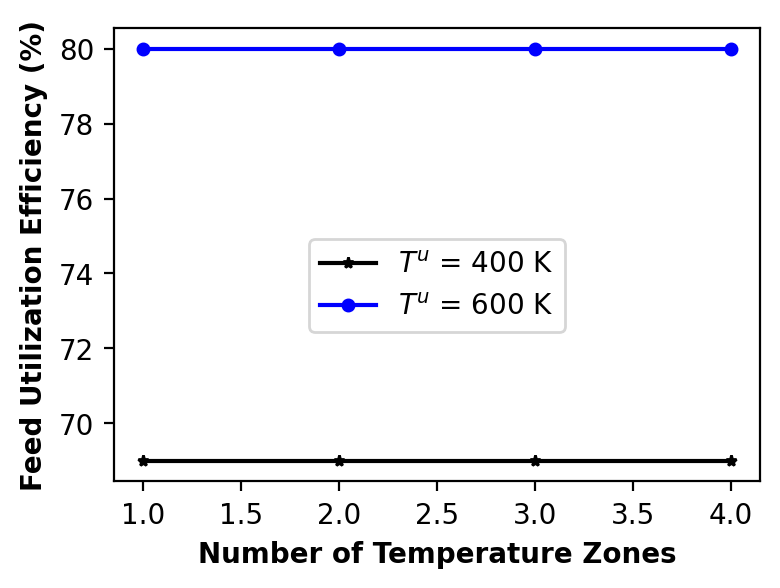

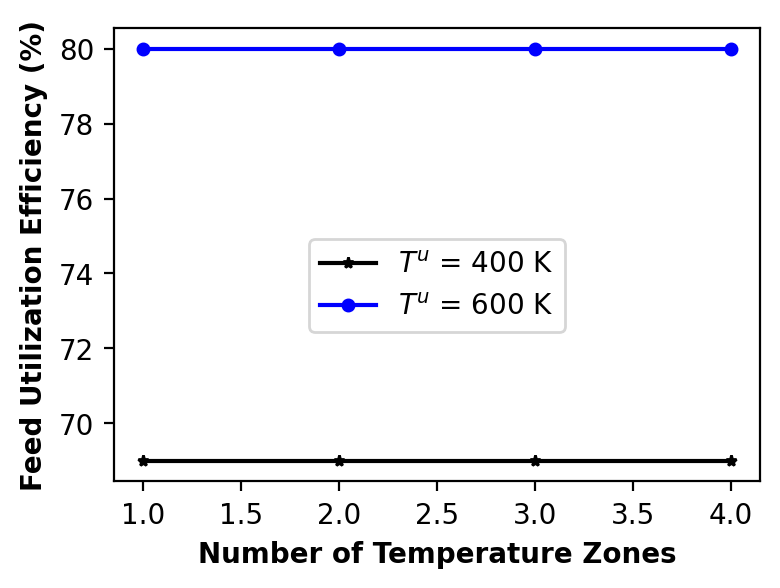

In [27]:
plot_pd_modified(data=kgH2_pd2,
                     x_label = 'Number of Temperature Zones',
            y_label='Feed Utilization Efficiency (%)',
            y_lim=[], txt=None, txt_loc=None,
            show_legend=True, legend_loc=(0.5, 0.3), legend_col=1,
            save_fig=savefig) #y_ticks=np.arange(75,105,5),

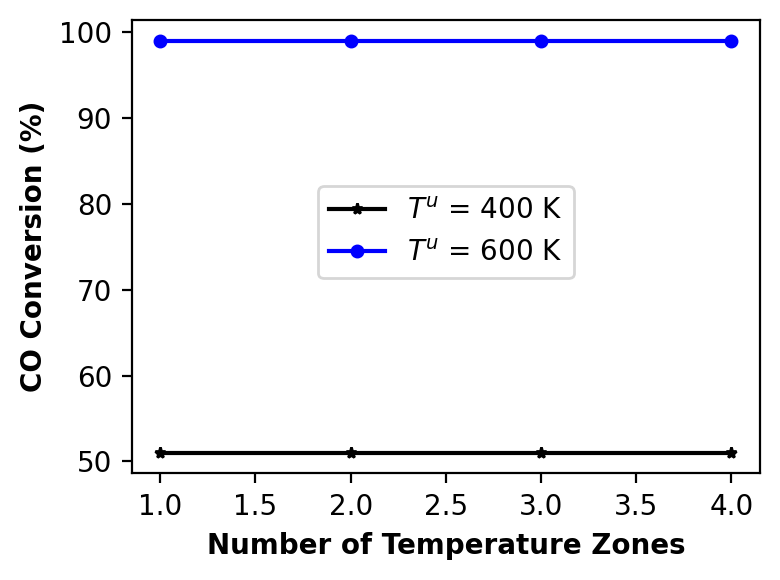

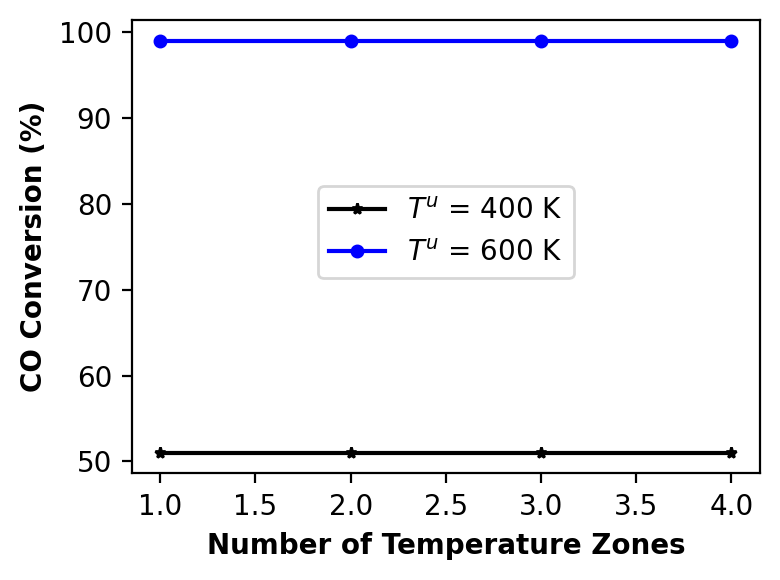

In [28]:
plot_pd_modified(data=conversion,
                     x_label = 'Number of Temperature Zones',
            y_label='CO Conversion (%)',
            y_lim=[], txt=None, txt_loc=None,
            show_legend=True, legend_loc=(0.5, 0.4), legend_col=1,
            save_fig=savefig) #y_ticks=np.arange(75,105,5),

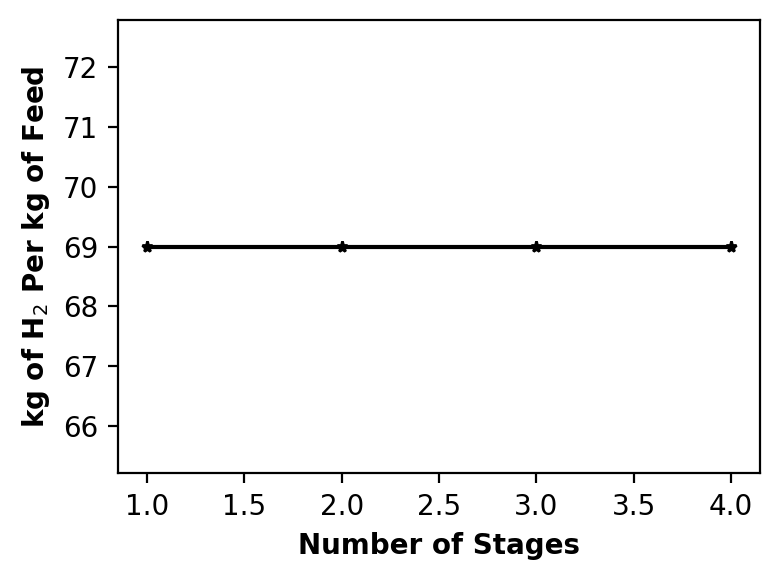

In [29]:
# plot results for Tmax = 800
# set matplotlib parameters
fig = plt.figure(figsize=(4,3),dpi=200)
plt.rcParams.update({"font.size": 10, "axes.labelweight":"bold"})

plt.plot(kgH2_pd2[kgH2_pd2.columns[0]],kgH2_pd2[kgH2_pd2.columns[1]], 'k*-', markersize=4)

# plt.yticks(np.arange(0.082,0.088,0.001))

plt.ylabel('kg of H$_2$ Per kg of Feed')

plt.xlabel('Number of Stages')
plt.tight_layout()

if savefig:
    plt.savefig('output/zoned_temperature_optimization_case2.pdf')
    plt.savefig('output/zoned_temperature_optimization_case2.png')